In [1]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, brier_score_loss
import arviz as az
import pymc3 as pm
import pymc3.sampling_jax
import arviz as az
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from relativeImp import relativeImp
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')
print(f"Running on PyMC3 v{pm.__version__}")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.11.2


/Users/es534/opt/anaconda3/envs/ds_env/lib/python3.7/site-packages/pymc3/sampling_jax.py:24: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [2]:

#Function for creating direct forecast DataFrame
def makeDirFcastDf2(df, p_lags0,p_lags1,p_lags2, q_lags, s_lags, z_lags, c_lags, date, target):
    new_df = pd.DataFrame()
    col = df.columns
    for h in range(1,21):
        new_df[f'{target}_0']=df[target]
        new_df[f'{target}_{h}']=df[target].shift(periods=-h)
    
        if q_lags == 0:
            pass
        elif q_lags == 1:
            new_df[f'{target}_lag_0']=df[target]
        elif q_lags >= 2:
            for q in range(1,q_lags):
                new_df[f'{target}_lag_0']=df[target]
                new_df[f'{target}_lag_{q}']=df[target].shift(periods=q)
        
        if p_lags0 == 0:
            pass
        elif p_lags0 == 1:
            new_df[f'{col[0]}_lag_0']=df[col[0]]
        elif p_lags0 >= 2:
            for p0 in range(1,p_lags0):
                new_df[f'{col[0]}_lag_0']=df[col[0]]
                new_df[f'{col[0]}_lag_{p0}']=df[col[0]].shift(periods=p0)
        
        if p_lags1 == 0:
            pass
        elif p_lags1 == 1:
            new_df[f'{col[1]}_lag_0']=df[col[1]]
        elif p_lags1 >= 2:
            for p1 in range(1,p_lags1):
                new_df[f'{col[1]}_lag_0']=df[col[1]]
                new_df[f'{col[1]}_lag_{p1}']=df[col[1]].shift(periods=p1)
        
        if p_lags2 == 0:
            pass
        elif p_lags2 == 1:
            new_df[f'{col[2]}_lag_0']=df[col[2]]
        elif p_lags2 >= 2:
            for p2 in range(1,p_lags2):
                new_df[f'{col[2]}_lag_0']=df[col[2]]
                new_df[f'{col[2]}_lag_{p2}']=df[col[2]].shift(periods=p2)
#         
        
        if s_lags == 1:
            new_df['Season_Code_lag_0']=df['Season_Code']

        if z_lags == 1:
            new_df['AEZ_Code_lag_0']=df['AEZ_Code']
        
        if c_lags == 1:
            new_df['County_Code_lag_0']=df['County_Code']
        
        if date == 1:
            new_df['Date_lag_0']=df['Date']
    
    return new_df


#Function for spliting data in to training and test set DataFrame
def fcast_train_testDF1(df, p_order0,p_order1,p_order2,q_order, target_var, s_lags, z_lags, c_lags,date, f_horizon=None):

    newdf_ls = []
    X_train2 = pd.DataFrame()
    ssn_ = df.Season.unique().tolist()
    cty_ = df.County.unique().tolist()
    aez_ = df.AEZ.unique().tolist()

    
    
    for c in cty_:
        df2 = df[df.County == c]
        for z in df2.AEZ.unique().tolist():
            df3 = df2[df2.AEZ == z]
            newdf1 = makeDirFcastDf2(df3,p_order0,p_order1, p_order2, q_order, s_lags, z_lags, c_lags,date, target_var)
            useDF1 = newdf1.loc[:,[g for g in newdf1.columns if 'lag' in g]]
    
            useDF1[f'{target_var}_{f_horizon}'] = newdf1[f'{target_var}_{f_horizon}']
            X_train = useDF1.dropna()
            newdf_ls.append(X_train)
    
    X_train2 = pd.concat(newdf_ls, axis=0)
    y_train = X_train2.loc[:,f'{target_var}_{f_horizon}']
    return X_train2, y_train, ssn_, cty_, aez_


def scaleValues(df, target):
    sdf = df.iloc[:,:-7]
    print(sdf.columns)
    sdf1 = (sdf-sdf.mean())/sdf.std()
    sdf1[target] = df[target]/100
    sdf1['Season'] = df.Season
    sdf1['AEZ'] = df.Zone
    sdf1['County'] = df.County
    sdf1['County_Code'] = df.County_Code
    sdf1['AEZ_Code'] = df.Zone_Code
    sdf1['Season_Code'] = df.Season_Code
    sdf1['Date'] = df.Date
    
    return sdf1


def detrend(df, target):
    df_ls = []
    means0 = {'county':[],'AEZs':[], 'means':[]}
    for c in df.County.unique().tolist():
        df2 = df[df.County == c]
        for z in df2.Zone.unique().tolist():
            df4 = df2[df2.Zone == z]
            tgmeans = df4[[target]].mean()
            df4[target] = df4[[target]] - tgmeans
            means0['county'].append(c)
            means0['AEZs'].append(z)
            means0['means'].append(tgmeans.values[0]/100)
            df_ls.append(df4)
    return pd.concat(df_ls), means0

def testSet(f):
    sub_ls=[]
    cty = f.split('/')[4].split('_')[1]
    ndf = pd.read_csv(f)
    aezone = ndf.Zone.unique()
    for z in aezone:
        subndf1 = ndf[ndf.Zone == z]
        
        subndf1['Date'] = pd.to_datetime(subndf1['Date'])
        subndf1 = subndf1.set_index('Date')
        subndf2 = subndf1[(subndf1.index.year > 2015)]
    
        subndf2['County'] = cty
        subndf2['County'] = subndf2['County'].astype('category')
        subndf2['County_Code'] = subndf2['County'].cat.codes
       
        subndf2['Date'] = subndf2.index
        subndf2.index = np.arange(len(subndf2))
        sub_ls.append(subndf2)
    testDf = pd.DataFrame()
    testDf = pd.concat(sub_ls)
    return testDf, cty

def addSeason(_df):
    _df['Date'] = pd.to_datetime(_df['Date'])
    df2 = _df.set_index('Date')

    df2['Month'] = df2.index.month

    jf = df2[(df2.Month>=1) & (df2.Month<=2)]
    jf['Season']  = 'jf'
    mam = df2[(df2.Month>=3) & (df2.Month<=5)]
    mam['Season']  = 'mam'
    jja = df2[(df2.Month>=6) & (df2.Month<=9)]
    jja['Season']  = 'jja'
    ond = df2[(df2.Month>=10) & (df2.Month<=12)]
    ond['Season']  = 'ond'
    new_sdf = pd.concat([jf, mam, jja, ond])
    new_sdf = new_sdf.sort_values(by='Date')
    return new_sdf.reset_index()

In [3]:
def PrepData(tr_df, lst_p0,precip_p1,soil_p2,targ_q, target, f_horizon=None, anom=None, growing_ssn=None):
    
    if anom == True:
        vars_abs = ['LST_Anom','Rainfall_Anom', 'SoilMoist_Anom',f'{target}','Zone', 'Zone_Code','County', 'County_Code', 'Season', 'Season_Code','Date']
    elif anom ==False:
        vars_abs = ['LST','Rainfall', 'SoilMoist',f'{target}','Zone', 'Zone_Code','County', 'County_Code', 'Season', 'Season_Code','Date']
    
    pq_order = [lst_p0,precip_p1,soil_p2,targ_q]

    tr_df['Rainfall'] = tr_df['Rainfall'].ewm(com=5).mean()

    if growing_ssn == 'MAM':
        tr_df = tr_df.loc[tr_df['Season'].isin(['mam'])]
    elif growing_ssn == 'OND':
        tr_df = tr_df.loc[tr_df['Season'].isin(['ond'])]
    else:
        pass
    
    
    tr_df2, target_means = detrend(tr_df, target)
    
    scale_df = scaleValues(tr_df2.loc[:,vars_abs], target)

    X_trainX, y_trainX, ssn_grp, cty_grp, aez_grp = fcast_train_testDF1(scale_df, p_order0=pq_order[0] ,
                                                                    p_order1=pq_order[1], p_order2=pq_order[2], 
                                                                    q_order=pq_order[3],s_lags=1, z_lags=1, c_lags=1,date=1,
                                                                    target_var=target,
                                                                    f_horizon=f_horizon)
#     print(X_trainX.columns)
    return X_trainX, y_trainX, ssn_grp, cty_grp, aez_grp, target_means

In [25]:
labels2 = [
    'Precipitation Anomaly Lag0',
 'Precipitation Anomaly Lag1',
 'Precipitation Anomaly Lag2',
 'Precipitation Anomaly Lag3',
 'Precipitation Anomaly Lag4',
 'Precipitation Anomaly Lag5',
 'Soil Moisture Anomaly Lag0',
 'Soil Moisture Anomaly Lag1',
 'Soil Moisture Anomaly Lag2',
 'Soil Moisture Anomaly Lag3',
 'Soil Moisture Anomaly Lag4',
 'Soil Moisture Anomaly Lag5',
 'VCI Lag0',
 'VCI Lag1',
 'VCI Lag2',
 'VCI Lag3',
 'VCI Lag4',
 'VCI Lag5']
def calcRelImp(data, target, anom):
    az_class_name = ['Humid','Semi-Humid','Semi-Arid','Arid','Very-Arid']
    df_ls = []
    for h in [4,6,8,10,12]:
        X_train, y_train, ssn_grp_test, cty_grp_test, aez_grp_test, test_means = PrepData(data, lst_p0=0,precip_p1=6,soil_p2=6,targ_q=6, target=target, f_horizon=h, anom=anom, growing_ssn=None)
        for z in aez_grp_test:
            use_x = X_train[X_train['AEZ_Code_lag_0']==az_class_name.index(z)]

            X_data = use_x.drop(['AEZ_Code_lag_0','Season_Code_lag_0', 'County_Code_lag_0','Date_lag_0', y_train.name], axis=1)
            y_data = use_x.iloc[:,-1]

            indep = X_data.columns.tolist()
            dep = y_data.name
            X_data[y_data.name] = y_data
            df_results = relativeImp(X_data, outcomeName = dep , driverNames = indep)
            df_results['Horizon'] = np.repeat(f'Horizon_{h}', len(df_results))
            df_results['AEZ'] = np.repeat(z, len(df_results))
            df_ls.append(df_results)

    return pd.concat(df_ls)

def plotRelImp(results, groups_level, target, title='Title'):
    
    class_name = ['Humid','Semi-Humid','Semi-Arid','Arid','Very-Arid','empty']
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15,16))
#     fig.suptitle(f'{title} for {groups_level}', y=1, fontsize=24)
    for a, ax in enumerate(axs.reshape(-1)):
        zx = class_name[a]
        if zx != 'empty':
            subResults= results[results[groups_level]==zx]
            hor = ['driver', 'Horizon_4','Horizon_6','Horizon_8','Horizon_10','Horizon_12']
            trans = pd.pivot_table(subResults, values=['normRelaImpt'], columns=['driver'], index=['Horizon'])
            trans = trans.T.reset_index()
            trans = trans.loc[:, hor]
            trans1 = trans.set_index('driver')

            colors = []
            if target == 'NDVI':
                cmaps = ['YlOrBr_r', 'Purples_r','Blues_r', 'YlGn_r' ]
            elif target == 'VCI':
                cmaps = [ 'Blues_r','YlGn_r', 'Purples_r']
            elif target == 'VHI':
                cmaps = ['YlOrBr_r','Blues_r','YlGn_r','Purples_r']

            for c in cmaps:
                colors.extend(sns.color_palette(c, n_colors=6))
            cmap1 = LinearSegmentedColormap.from_list("my_colormap", colors)

            trans1.T.plot(kind='bar', stacked=True, width=0.9, cmap=cmap1, legend=False, ax=ax)
            ax.set_ylabel('Percentage Relative Importance (%)', fontsize=16)
            ax.set_xlabel('Forecast Horizon (Lead Times)', fontsize=16)
            ax.set_title(f'{target} {zx}', fontsize=18)
            ax.set_xticklabels(['4', '6', '8', '10', '12'], rotation='horizontal', fontsize=13)
            handles, labels = ax.get_legend_handles_labels()
        elif zx == 'empty':
             fig.delaxes(ax)
            
#     fig.legend(handles, labels2, ncol=3, loc='center center', bbox_to_anchor=(1.00, -0.1), fontsize=14, fancybox=True, shadow=True)
#     plt.tight_layout()
    
        plt.subplots_adjust(left=0.125,
                                    bottom=0.1, 
                                    right=0.9, 
                                    top=0.9, 
                                    wspace=0.3, 
                                    hspace=0.3)
        plt.legend(handles, labels2, ncol=3, bbox_to_anchor=(0.99, -0.65), loc='center', fontsize=16)
        plt.savefig('relimp_AEZ2.pdf', bbox_inches='tight')
        
def plotRelImp2(results, groups_level, target, title='Title'):
    
    class_name = ['Humid','Semi-Humid','Semi-Arid','Arid','Very-Arid','empty']
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15,16))
#     fig.suptitle(f'{title} for {groups_level}', y=1, fontsize=24)
    for a, ax in enumerate(axs.reshape(-1)):
        zx = class_name[a]
        if zx != 'empty':
            subResults= results[results[groups_level]==zx]
            hor = ['driver', 'Horizon_4','Horizon_6','Horizon_8','Horizon_10','Horizon_12']
            trans = pd.pivot_table(subResults, values=['normRelaImpt'], columns=['driver'], index=['Horizon'])
            trans = trans.T.reset_index()
            trans = trans.loc[:, hor]
            trans1 = trans.set_index('driver')

            colors = []
            if target == 'NDVI':
                cmaps = ['YlOrBr_r', 'Purples_r','Blues_r', 'YlGn_r' ]
            elif target == 'VCI':
                cmaps = [ 'Blues_r','YlGn_r', 'Purples_r']
            elif target == 'VHI':
                cmaps = ['YlOrBr_r','Blues_r','YlGn_r','Purples_r']

            for c in cmaps:
                colors.extend(sns.color_palette(c, n_colors=6))
            cmap1 = LinearSegmentedColormap.from_list("my_colormap", colors)

            trans1.T.plot(kind='bar', stacked=False, width=0.9, cmap=cmap1, legend=False, ax=ax)
            ax.set_ylabel('Percentage Relative Importance (%)', fontsize=16)
            ax.set_xlabel('Forecast Horizon (Lead Times)', fontsize=16)
            ax.set_title(f'{target} {zx}', fontsize=18)
            ax.set_xticklabels(['4', '6', '8', '10', '12'], rotation='horizontal', fontsize=13)
            handles, labels = ax.get_legend_handles_labels()
        elif zx == 'empty':
             fig.delaxes(ax)
            
#     fig.legend(handles, labels2, ncol=3, loc='center center', bbox_to_anchor=(1.00, -0.1), fontsize=14, fancybox=True, shadow=True)
#     plt.tight_layout()
    
        plt.subplots_adjust(left=0.125,
                                    bottom=0.1, 
                                    right=0.9, 
                                    top=0.9, 
                                    wspace=0.3, 
                                    hspace=0.3)
        plt.legend(handles, labels2, ncol=3, bbox_to_anchor=(0.99, -0.65), loc='center', fontsize=16)
        plt.savefig('relimp_AEZ2.pdf', bbox_inches='tight')

In [21]:
county103 = [
'Marsabit',
'Kitui',
'Baringo',
'Tana-River',
'Turkana',
'Narok'
]
trainDF2 = pd.read_csv('AEZ_Extract/Merged/Smooth_AEZ/AEZ_3M/HBM_train_df_3M_Sub_pft.csv')
az_class_name = ['Humid','Semi-Humid','Semi-Arid','Arid','Very-Arid']
sub_trainDF = trainDF2.loc[trainDF2.County.isin(county103)]

Index(['LST_Anom', 'Rainfall_Anom', 'SoilMoist_Anom', 'VCI'], dtype='object')
Index(['LST_Anom', 'Rainfall_Anom', 'SoilMoist_Anom', 'VCI'], dtype='object')
Index(['LST_Anom', 'Rainfall_Anom', 'SoilMoist_Anom', 'VCI'], dtype='object')
Index(['LST_Anom', 'Rainfall_Anom', 'SoilMoist_Anom', 'VCI'], dtype='object')
Index(['LST_Anom', 'Rainfall_Anom', 'SoilMoist_Anom', 'VCI'], dtype='object')


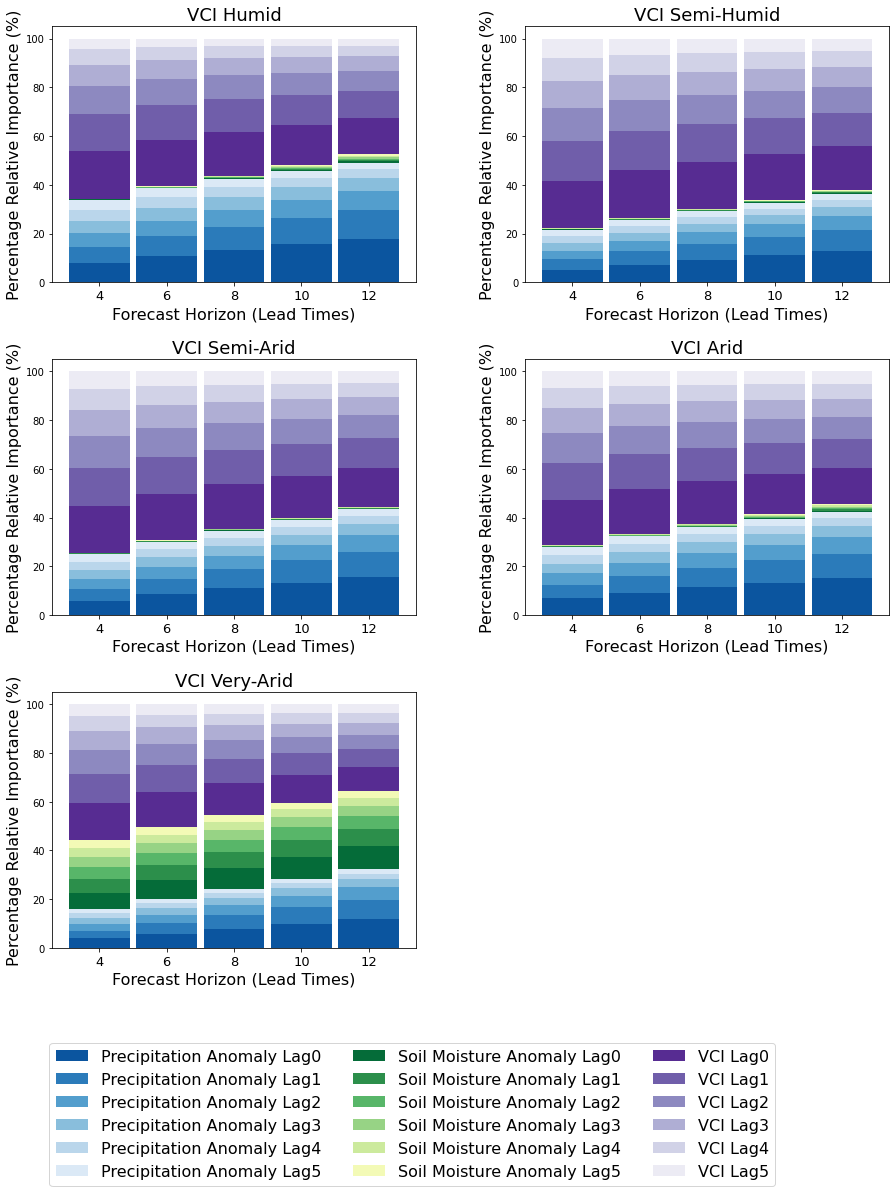

In [22]:
rel_impDF = calcRelImp(sub_trainDF, 'VCI', anom=True)
plotRelImp(rel_impDF, 'AEZ', 'VCI', title='Anomaly VCI 3M ')

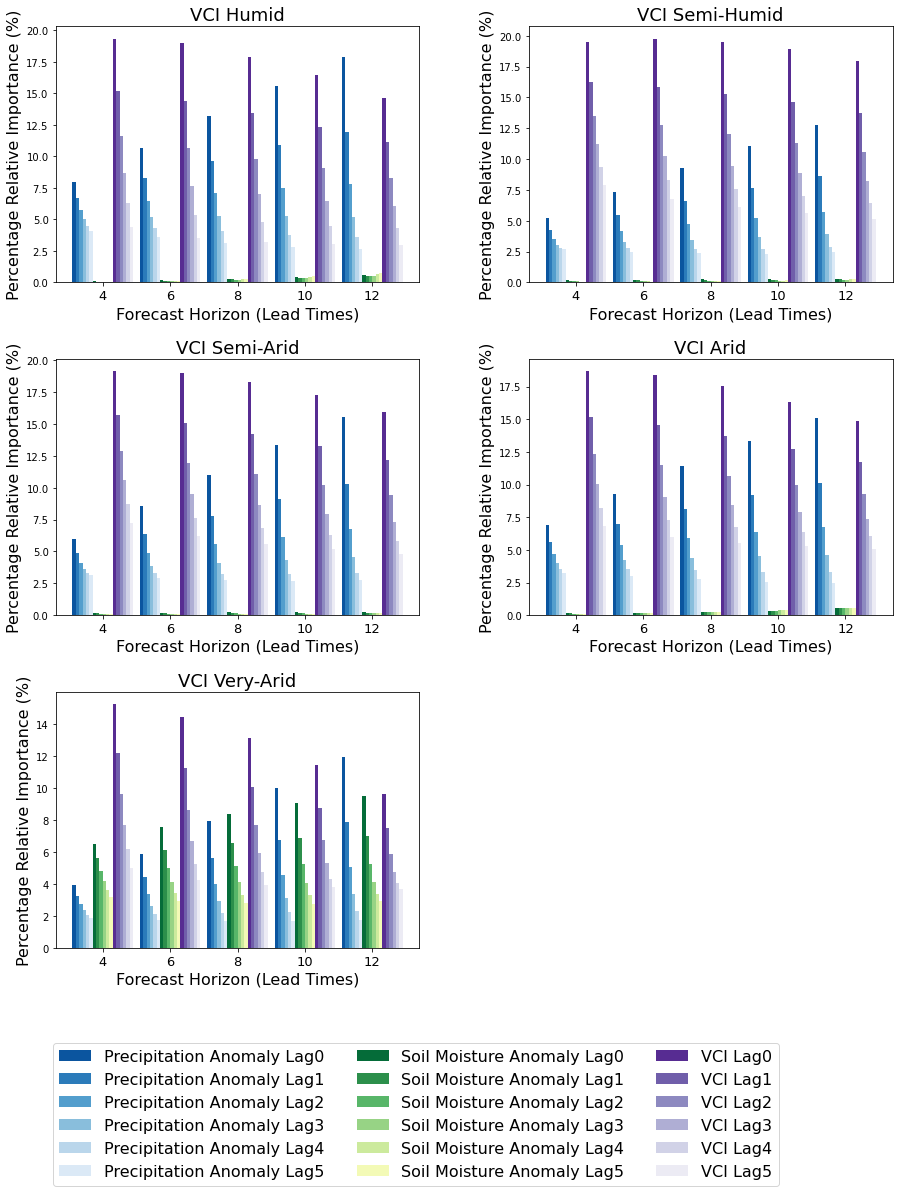

In [26]:
plotRelImp2(rel_impDF, 'AEZ', 'VCI', title='Anomaly VCI 3M ')

In [116]:
# PLOT ROC CURVES
def plotROC(df, name, data):
    FPs,FNs,TPs,TNs = [],[],[],[]
    FPR,TPR = [],[]
    Hor = []

    fig,ax1 = plt.subplots(figsize=(8,8))


#     ax1.set_prop_cycle(plt.cycler('color', ['black', '#1f77b4', '#ff7f0e', '#2ca02c','#d62728']))
    ax1.set_prop_cycle(plt.cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#74bfe8']))

    AreaPerWeek = []
    something = 0 

    HWeeks=[4,6,8,10,12]
    for hweek in HWeeks:
        fhor = df[(df['Horizon']==hweek)]
        if data == 'VCI':
            forecast = fhor.VCI_Forecast.values*100
            actual  = fhor.VCI_Observed.values*100
        elif data == 'NDVI':
            forecast = fhor.VCI_Predicted.values
            actual  = fhor.VCI_Observed.values

        FPR,TPR = [],[]
        Hor.append(np.repeat(hweek, len(actual)))

        for VCI in np.arange(0,len(actual)):

                FP,FN,TP,TN = 0,0,0,0

                for item,item2 in zip(actual,forecast): 

                    if item < VCI and item2 <35:
                        TP +=1
                    elif item < VCI and item2 > 35:
                        FP +=1
                    elif item > VCI and item2 < 35:
                        FN +=1
                    elif item > VCI and item2 >35:
                        TN +=1

                FPs.append(FP)
                FNs.append(FN)
                TPs.append(TP)
                TNs.append(TN)
               

                try:
                    TPR.append(TP/(TP+FN))
                except:
                    TPR.append(1)

                try:
                    FPR.append(FP/(FP+TN)) 
                except:
                    FPR.append(0)
                
                if VCI == 35:
                    if something == 0:
                        try:
                            ax1.scatter(FP/(FP+TN),TP/(TP+FN),s=45,label = ('VCI < 35'))    
                            something +=1
                        except:
                            something +=1
                    else:
                        try:
                            ax1.scatter(FP/(FP+TN),TP/(TP+FN),s=45)    
                        except:
                            print('Name')
          
        AUC = np.trapz(TPR,FPR,dx=0.001)        
        ax1.plot(FPR,TPR,label='{} Week forcast time \nAUC = {}'.format(hweek,round(AUC,2)))
            #ax1.plot(FPR,TPR,label =('Week' + str(weeks)+ '\nAUC = ' +str(np.round(AUC,2))))

        AreaPerWeek.append(AUC)


        yx = np.linspace(0,1,10)
        ax1.plot(yx,yx,dashes=[6, 2],color='black')

        ax1.set_xlim(0,1)
        ax1.set_ylim(0,1)
        ax1.legend(fontsize=15)
        ax1.grid(True)
        ax1.set_title(f'ROC {name}', fontsize=16)
        ax1.set_ylabel('True Positive Rate', fontsize=16)
        ax1.set_xlabel('False Positive Rate', fontsize=16)
        plt.savefig(f'ROC-{name}.pdf',dpi=400, bbox_inches='tight')
        
    #     plt.savefig('{}{}.pdf'.format(file_path,key),dpi=400)
    #     plt.show()
        print(np.array(AreaPerWeek)*100)
        print(TPs[34],FPs[34],FNs[34],TNs[34])
        
        pd.DataFrame({'TPR':TPR, 'FPR':FPR}).to_csv(f'ROC_Metrics_{name}_{hweek}.csv')

In [48]:
### MAKE FREQUENCY TABLE FOR RELIABILITY DIAGRM
def getFreqs1(df,forecast_probs,observed_binary, bin_steps=0.2):
    freqs = {'Horizon':[],'FcastProbs':[],'Fcastfreqs':[], 'Obsfreq':[]}
    fps = np.arange(0, 1.1, bin_steps)
    for f in [4,6,8,10,12]:
        subA = df[df['Horizon']==f]
        subB = subA.loc[:,[forecast_probs,observed_binary]]
        for i in fps:
            fcounts1 = [subB[(subB[forecast_probs]>=i)&(subB[forecast_probs]<=i+bin_steps)]]
            freqs['Fcastfreqs'].append(len(fcounts1[0]))
            freqs['Obsfreq'].append(len(fcounts1[0][fcounts1[0][observed_binary]==1]))
            freqs['FcastProbs'].append(i)
            freqs['Horizon'].append(f)
                
    freqs_out = pd.DataFrame(freqs)
    freqs_out['Obs_Freq'] = freqs_out['Obsfreq']/freqs_out['Fcastfreqs']
    return freqs_out

### FUNCTION FOR PICP AND MPIEW 
def getPICI_AR(observed, upper, lower):
    p_upper = upper
    p_lower = lower
    ci = []
    for i in range(len(p_upper)):
        c = p_lower[i] < observed[i] and observed[i] < p_upper[i]
        if c == True:
            ci.append(1)
        else:
            pass
    return sum(ci)/len(p_upper), sum(p_upper-p_lower)/len(p_upper)


def joinDf(dflist):
    VCIO_ls = []
    for v in dflist:
        VCIO_ls.append(pd.read_csv(v))
    return pd.concat(VCIO_ls)



### READ IN DATA FROM FORECAST OUT PUTS

In [49]:
county103 = [
'Marsabit',
'Kitui',
'Baringo',
'Tana-River',
'Turkana',
'Narok'
]

county101 = [
'West-Pokot',
'Wajir',
'Mandera',
'Samburu',
'Laikipia',
'Kajiado',
'Isiolo',
'Taita-Taveta',
'Garissa',
'Nyeri'
]

UnPool_df = joinDf(glob.glob('Forecast_Out/Out_New/AEZ*Unpooled*AEZNew.csv')) #UNPOOLED DATA
# Pool_df = joinDf(glob.glob('../Forecast_Out/Out_New/AEZ*_Pooled*csv'))
partPool_df= joinDf(glob.glob('Forecast_Out/Out_New/AEZ*PartPooled*New.csv')) # PARTIAL POOLED 

In [50]:
PartPoolTr = partPool_df[partPool_df.County.isin(county103)] # WITH TRAIN COUNTIES 
PartPoolTran = partPool_df[partPool_df.County.isin(county101)] # WITH NON TRAINING COUNTIES

In [52]:
for p in [UnPool_df, PartPoolTr]:
    print(p.County.unique())

['Baringo' 'Kitui' 'Tana-River' 'Turkana' 'Narok' 'Marsabit']
['Marsabit' 'Kitui' 'Baringo' 'Tana-River' 'Turkana' 'Narok']


In [53]:
for c in PartPoolTr.County.unique():
    sub0 = PartPoolTr[PartPoolTr.County==c]
    print(f'{c} | {sub0.AEZ.unique().tolist()}')

Marsabit | ['Semi-Humid', 'Semi-Arid', 'Arid', 'Very-Arid']
Kitui | ['Semi-Humid', 'Semi-Arid', 'Arid', 'Very-Arid']
Baringo | ['Humid', 'Semi-Humid', 'Semi-Arid', 'Arid']
Tana-River | ['Semi-Arid', 'Arid', 'Very-Arid']
Turkana | ['Semi-Arid', 'Arid', 'Very-Arid']
Narok | ['Humid', 'Semi-Humid', 'Semi-Arid']


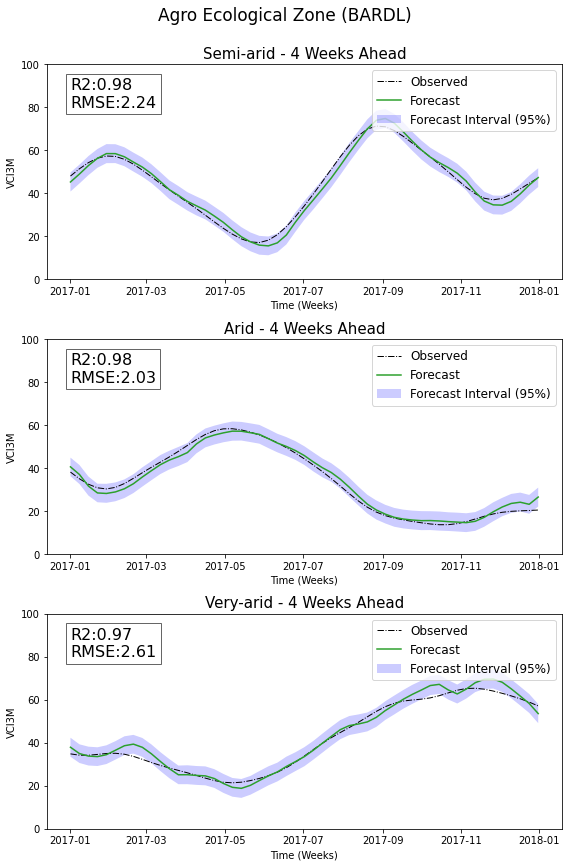

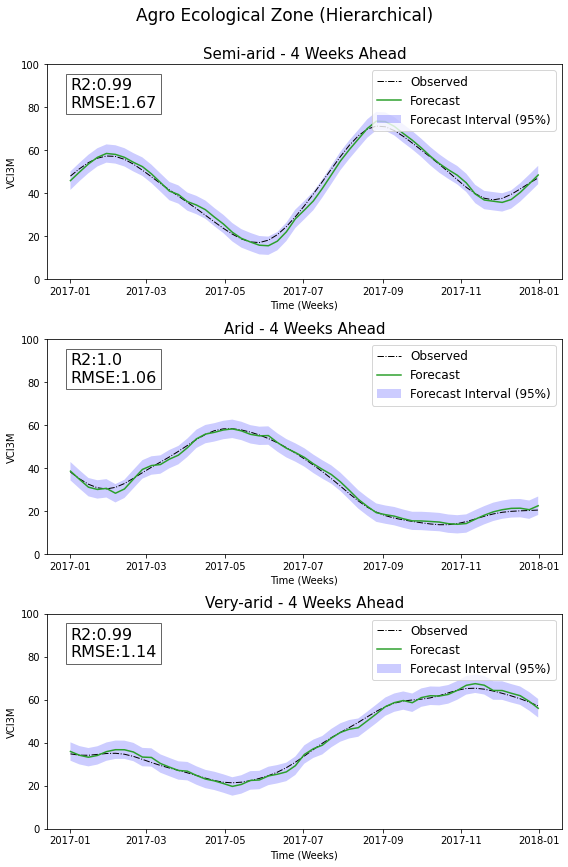

In [18]:
start = datetime.datetime.strptime('2017-01-01','%Y-%m-%d' )
stop = datetime.datetime.strptime('2017-12-31','%Y-%m-%d' )

cty = ['Turkana']
color0 = ['#ff7f0e', '#2ca02c','#d62728','#b516a5']
# sub0 = allPredsTrain[(allPredsTrain.County=='Mandera') & (allPredsTrain.Horizon==4)]
sub0 = UnPool_df[(UnPool_df.County.isin(cty)) & (UnPool_df.Horizon==4)]
aez = sub0.AEZ.unique()
sub0['Date'] = pd.to_datetime(sub0.Date)
fig, axs = plt.subplots(nrows=len(aez), ncols=1, figsize=(8,12))
fig.suptitle(f'Agro Ecological Zone (BARDL)', y=1.0, fontsize=17)
for a, ax in enumerate(axs.reshape(-1)):
    v = aez[a]
    sub_data = sub0[sub0.AEZ == v]
    sub_data = sub_data[sub_data.Date.dt.year==2017]
    r2c = r2_score(sub_data['VCI_Observed'], sub_data['VCI_Forecast'])
    rmse3 = np.sqrt(mean_squared_error(sub_data['VCI_Observed'], sub_data['VCI_Forecast']))
    ax.set_title(f'{v.capitalize()} - 4 Weeks Ahead', fontsize=15)
    ax.plot(sub_data.Date, sub_data.VCI_Observed*100, ls='-.', lw=1, color='k', label='Observed')
    ax.plot(sub_data.Date, sub_data.VCI_Forecast*100, color='#2ca02c', label='Forecast')
    ax.fill_between(sub_data.Date, sub_data.VCI_Upper1*100, sub_data.VCI_Lower0*100, facecolor='blue', alpha=0.2, label='Forecast Interval (95%)')
    txt0 = ax.text(x=start, y=80, s=f'R2:{r2c.round(2)}\nRMSE:{(rmse3*100).round(2)}', fontsize=16)
    txt0.set_bbox(dict(facecolor='white', alpha=0.6))
    ax.set_yticks(np.arange(0, 101, 20))
    ax.set_xlabel('Time (Weeks)')
    ax.set_ylabel('VCI3M')
    ax.legend(loc='upper right', fontsize=12)
    plt.tight_layout()
plt.savefig(f'AEZ_TC_TS3 (No Pooled).pdf',  bbox_inches='tight')

sub0 = PartPoolTr[(PartPoolTr.County.isin(cty)) & (PartPoolTr.Horizon==4)]
aez = sub0.AEZ.unique()
sub0['Date'] = pd.to_datetime(sub0.Date)
fig, axs = plt.subplots(nrows=len(aez), ncols=1, figsize=(8,12))
fig.suptitle(f'Agro Ecological Zone (Hierarchical)', y=1.0, fontsize=17)
for a, ax in enumerate(axs.reshape(-1)):
    v = aez[a]
    sub_data = sub0[sub0.AEZ == v]
    sub_data = sub_data[sub_data.Date.dt.year==2017]
    r2c = r2_score(sub_data['VCI_Observed'], sub_data['VCI_Forecast'])
    rmse3 = np.sqrt(mean_squared_error(sub_data['VCI_Observed'], sub_data['VCI_Forecast']))
    ax.plot(sub_data.Date, sub_data.VCI_Observed*100, ls='-.', lw=1, color='k', label='Observed')
    ax.plot(sub_data.Date, sub_data.VCI_Forecast*100, color='#2ca02c', label='Forecast')
    ax.set_title(f'{v.capitalize()} - 4 Weeks Ahead', fontsize=15)

#     ax.set_title(f'{v.capitalize()} - 4 Weeks Ahead\nR2:{r2c.round(2)}\nRMSE:{(rmse3*100).round(2)}', fontsize=15)
    ax.fill_between(sub_data.Date, sub_data.VCI_Upper1*100, sub_data.VCI_Lower0*100, facecolor='blue', alpha=0.2, label='Forecast Interval (95%)')
    ax.set_xlabel('Time (Weeks)')
    ax.set_ylabel('VCI3M')
    txt0 = ax.text(x=start, y=80, s=f'R2:{r2c.round(2)}\nRMSE:{(rmse3*100).round(2)}', fontsize=16)
    txt0.set_bbox(dict(facecolor='white', alpha=0.6))
    ax.set_yticks(np.arange(0, 101, 20))
    ax.legend(loc='upper right', fontsize=12)
    plt.tight_layout()
plt.savefig(f'AEZ_TC_TS3 (Hierarchical).pdf',  bbox_inches='tight')
# plt.savefig(f'../LC_TC_TS3.png',  bbox_inches='tight')

# ANALYSIS OF ONSET AND END OF DROUGHT

353    9.491667
Name: FDrought, dtype: float64 371    73.483333
Name: FDrought, dtype: float64
2588    77.331667
Name: FDrought, dtype: float64 2606    57.513333
Name: FDrought, dtype: float64


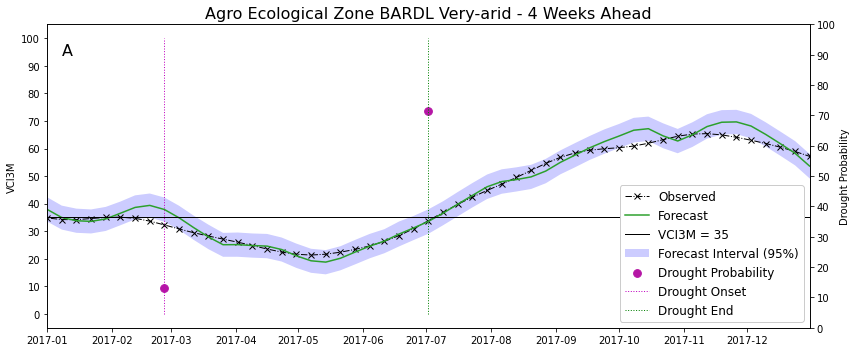

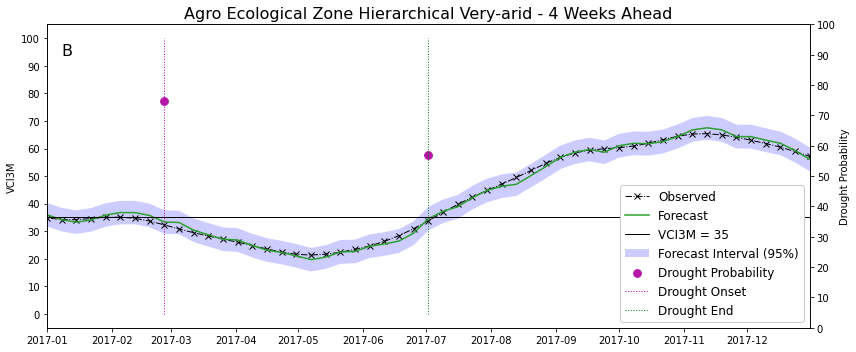

In [49]:
start = datetime.datetime.strptime('2017-01-01','%Y-%m-%d' )
stop = datetime.datetime.strptime('2017-12-31','%Y-%m-%d' )
stop2 = datetime.datetime.strptime('2017-11-10','%Y-%m-%d' )
stop3 = datetime.datetime.strptime('2017-01-08','%Y-%m-%d' )
for z in [(UnPool_df, 'BARDL','A'), (PartPoolTr, 'Hierarchical','B')]:
    h=4
    cty = ['Turkana']
    color0 = ['#ff7f0e', '#2ca02c','#d62728','#b516a5']
    # sub0 = allPredsTrain[(allPredsTrain.County=='Mandera') & (allPredsTrain.Horizon==4)]
    sub0 = z[0][(z[0].County.isin(cty)) & (z[0].Horizon==h)]
    sub0['Date'] = pd.to_datetime(sub0.Date)
    # fig.suptitle(f'Agro Ecological Zone No Pooling', y=1.0, fontsize=17)
    sub_data = sub0[sub0.AEZ == 'Very-Arid']
    r2c = r2_score(sub_data['VCI_Observed'], sub_data['VCI_Forecast'])
    rmse3 = np.sqrt(mean_squared_error(sub_data['VCI_Observed'], sub_data['VCI_Forecast']))
    fig, ax1 = plt.subplots(figsize=(12,5))
#     plt.figure(figsize=(12,5))
    ax1.set_title(f'Agro Ecological Zone {z[1]} {v.capitalize()} - {h} Weeks Ahead', fontsize=16)
    ax1.plot(sub_data.Date, sub_data.VCI_Observed*100, marker="x", ls='-.', lw=1, color='k', label='Observed')
    ax1.plot(sub_data.Date, sub_data.VCI_Forecast*100, color='#2ca02c', label='Forecast')
    ax1.fill_between(sub_data.Date, sub_data.VCI_Upper1*100, sub_data.VCI_Lower0*100, facecolor='blue', alpha=0.2, label='Forecast Interval (95%)')
    ax1.set_ylabel('VCI3M')
    

#     use_prods = sub_data.where(sub_data['FDrought']>0.5)
#     use_prods = use_prods.where(use_prods['FDrought']<0.95)
    use_prods_1=sub_data[sub_data.Date=='2017-02-26']
    use_prods_2=sub_data[sub_data.Date=='2017-07-02']
    print(use_prods_1['FDrought']*100, use_prods_2['FDrought']*100)
    ax1.scatter(use_prods_1.Date, use_prods_1['FDrought']*100, marker="o", color='#b516a5',s=60, label='Drought Probability')
    ax1.scatter(use_prods_2.Date, use_prods_2['FDrought']*100, marker="o", color='#b516a5', s=60)
    ax1.vlines(use_prods_1['Date'],0,100, ls=':', lw=1, color='m', label='Drought Onset')
    ax1.vlines(use_prods_2['Date'],0,100, ls=':', lw=1, color='g', label='Drought End')
    ax1.axhline(35, lw=1, color='k', label='VCI3M = 35')
    ax1.set_yticks(np.arange(0, 101, 10))
    ax2 = ax1.twinx()
    
#     ax2.scatter(use_prods_1.Date, use_prods_1['FDrought']*100, marker="o", color='#b516a5',s=60, label='Drought Probability')
    
    ax2.set_ylabel('Drought Probability')
    ax2.set_yticks(np.arange(0, 101, 10))
    ax2.set_xlim((start,stop))
    
    
    txt = plt.text(x=stop3, y=90, s=z[2], fontsize=16)
#     txt0 = plt.text(x=stop2, y=0.05, s=f'R2:{r2c.round(2)}\nRMSE:{(rmse3*100).round(2)}', fontsize=16)
    txt0.set_bbox(dict(facecolor='white', alpha=0.6))
    ax1.legend(loc='lower right', framealpha=1, fontsize=12)
    plt.tight_layout()
    plt.savefig(f'AEZ_TS_{h} ({z[1]}).pdf',  bbox_inches='tight')

### PLOT CONTOUR DISTS AND COMPUTE THE R2 AND RMSE

In [43]:
# allPredsAnom.to_csv('HBM_Forecast-test.csv')
def plotContours(df=None, sub_groups=None, model_type=None, agg=None, countys=None):
    if agg == 'per_county':
        cmetrics = []
        for c in countys:
            subData2 = df[df['County']==c]
            for lc in subData2[sub_groups].unique():
                subData1 = subData2[subData2[sub_groups]==lc]
                fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30,5))
                for a, ax in enumerate(axs.reshape(-1)):
                    h = [4,6,8,10,12][a]
                    subData = subData1[subData1.Horizon==h]

                    sns.kdeplot(subData['VCI_Forecast'], subData['VCI_Observed'], cmap='YlGn', ax=ax)

                    r2c = r2_score(subData['VCI_Observed'], subData['VCI_Forecast'])
                    mae3 = mean_absolute_error(subData['VCI_Observed'], subData['VCI_Forecast'])*100
                    rmse3 = np.sqrt(mean_squared_error(subData['VCI_Observed'], subData['VCI_Forecast']))*100
                    cmetrics.append(pd.DataFrame({'County':[c], f'{sub_groups}':[lc], 'Hor':[h],'R2':[r2c], 'MAE':[mae3], 'RMSE':[rmse3], 'FC_Type':model_type}))
                    ax.plot((0,1), (0,1), 'k--', lw=2.5)
                    ax.set_title(f'{c} {lc} -{model_type}', fontsize=16)
                    ax.set_ylim(0,1)
                    ax.set_xlim(0,1)

                    ax.set_xlabel(f'VCI Forecast at {h} Weeks', fontsize=12)
                    ax.set_ylabel(f'VCI Observed at {h} Weeks', fontsize=12)

                    txt0 = ax.text(x=0.5, y=0.05, s=f'R2:{r2c.round(3)}\nMAE:{mae3.round(3)}\nRMSE:{rmse3.round(3)}', fontsize=16)
                    txt0.set_bbox(dict(facecolor='white', alpha=0.6))    
                    plt.legend([],[], frameon=False)

        out_df = pd.concat(cmetrics)
    
    elif agg == 'all_county':
        metrics = []
        for lc in df[sub_groups].unique():
            subData1 = df[df[sub_groups]==lc]
            fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30,5))
            for a, ax in enumerate(axs.reshape(-1)):
                h = [4,6,8,10,12][a]
                subData = subData1[subData1.Horizon==h]

                sns.kdeplot(subData['VCI_Forecast'], subData['VCI_Observed'], cmap='YlGn', ax=ax)

                r2c = r2_score(subData['VCI_Observed'], subData['VCI_Forecast'])
                mae3 = mean_absolute_error(subData['VCI_Observed'], subData['VCI_Forecast'])*100
                rmse3 = np.sqrt(mean_squared_error(subData['VCI_Observed'], subData['VCI_Forecast']))*100
                metrics.append(pd.DataFrame({f'{sub_groups}':[lc], 'Hor':[h],'R2':[r2c], 'MAE':[mae3], 'RMSE':[rmse3], 'FC_Type':model_type}))
                ax.plot((0,1), (0,1), 'k--', lw=2.5)
                ax.set_title(f'{lc} -{model_type}', fontsize=16)
                ax.set_ylim(0,1)
                ax.set_xlim(0,1)

                ax.set_xlabel(f'VCI Forecast at {h} Weeks', fontsize=12)
                ax.set_ylabel(f'VCI Observed at {h} Weeks', fontsize=12)

                txt0 = ax.text(x=0.5, y=0.05, s=f'R2:{r2c.round(3)}\nMAE:{mae3.round(3)}\nRMSE:{rmse3.round(3)}', fontsize=16)
                txt0.set_bbox(dict(facecolor='white', alpha=0.6))    
                plt.legend([],[], frameon=False)
        out_df = pd.concat(metrics)
    return out_df

In [2]:
pmetricsUP = plotContours(df=UnPool_df, sub_groups='AEZ', model_type='No Pooling', agg='per_county', countys=county103)

NameError: name 'plotContours' is not defined

In [3]:
pmetricsPP = plotContours(df=PartPoolTr, sub_groups='AEZ', model_type='Hierarchical', agg='per_county', countys=county103)
pmetricsPPT = plotContours(df=partPool_df, sub_groups='AEZ', model_type='Hierarchical', agg='per_county', countys=county101)

NameError: name 'plotContours' is not defined

In [555]:
#MERGE METRICS FROM CONTOUR PLOTS 
pall_metrics = pd.concat([pmetricsUP, pmetricsPP])
pall_metrics.head()

,County,AEZ,Hor,R2,MAE,RMSE,FC_Type
0,Marsabit,Semi-Humid,4,0.926049,3.984447,5.066406,No Pooling
0,Marsabit,Semi-Humid,6,0.719796,8.037036,9.927062,No Pooling
0,Marsabit,Semi-Humid,8,0.464355,11.570517,13.819497,No Pooling
0,Marsabit,Semi-Humid,10,0.170919,14.812463,17.309270,No Pooling
0,Marsabit,Semi-Humid,12,-0.127455,17.351057,20.304280,No Pooling


In [556]:
# VIEW METRICS PIVOT TABLES
psub_Met = pall_metrics[pall_metrics.County=='Marsabit']
pall_metrics.pivot_table(columns=['Hor'], values=['R2','RMSE'], index=['FC_Type','County', 'AEZ'])

R2                                \
Hor                                       4         6         8         10   
FC_Type      County     AEZ                                                  
Hierarchical Baringo    Arid        0.995224  0.959149  0.840430  0.657954   
                        Humid       0.982511  0.877366  0.622943  0.312188   
                        Semi-Arid   0.993924  0.966213  0.899758  0.792633   
                        Semi-Humid  0.976711  0.903006  0.755169  0.531958   
             Kitui      Arid        0.989860  0.924283  0.734628  0.474653   
                        Semi-Arid   0.973220  0.891705  0.735161  0.531548   
                        Semi-Humid  0.959072  0.867582  0.721017  0.509978   
                        Very-Arid   0.995433  0.963694  0.874987  0.756990   
             Marsabit   Arid        0.991417  0.947538  0.834176  0.639728   
                        Semi-Arid   0.981352  0.918931  0.792174  0.603418   
                        Semi-Humid  0.937359  0.795681  0.593034  0.349557   
                        Very-Arid   0.996604  0.976728  0.915022  0.803861   
             Narok      Humid       0.991490  0.932990  0.778601  0.573449   
                        Semi-Arid   0.986640  0.932804  0.813236  0.633263   
                        Semi-Humid  0.971925  0.885484  0.720743  0.483952   
             Tana-River Arid        0.980528  0.867535  0.554935  0.169667   
                        Semi-Arid   0.937716  0.736381  0.413049  0.076636   
                        Very-Arid   0.996680  0.972877  0.902866  0.796860   
             Turkana    Arid        0.994955  0.959237  0.845331  0.672960   
                        Semi-Arid   0.985776  0.927639  0.797687  0.600554   
                        Very-Arid   0.995139  0.969011  0.896037  0.780331   
No Pooling   Baringo    Arid        0.984059  0.915132  0.780442  0.595240   
                        Humid       0.940385  0.728062  0.388366 -0.005510   
                        Semi-Arid   0.992352  0.957575  0.883639  0.770877   
                        Semi-Humid  0.981895  0.905434  0.759657  0.555142   
             Kitui      Arid        0.971644  0.865944  0.694659  0.491389   
                        Semi-Arid   0.966780  0.858362  0.698996  0.507293   
                        Semi-Humid  0.954471  0.834149  0.664667  0.434548   
                        Very-Arid   0.987418  0.935902  0.846055  0.740717   
             Marsabit   Arid        0.975588  0.900225  0.764983  0.574494   
                        Semi-Arid   0.974391  0.876753  0.702767  0.470855   
                        Semi-Humid  0.926049  0.719796  0.464355  0.170919   
                        Very-Arid   0.986629  0.944548  0.877911  0.784630   
             Narok      Humid       0.964817  0.842072  0.641851  0.408038   
                        Semi-Arid   0.981090  0.907025  0.771036  0.582055   
                        Semi-Humid  0.968489  0.861988  0.691264  0.461478   
             Tana-River Arid        0.950601  0.779000  0.512713  0.209812   
                        Semi-Arid   0.933300  0.726449  0.452924  0.140756   
                        Very-Arid   0.988083  0.945069  0.862813  0.747869   
             Turkana    Arid        0.983413  0.915100  0.782605  0.602300   
                        Semi-Arid   0.981820  0.903662  0.745537  0.522189   
                        Very-Arid   0.976867  0.908104  0.812854  0.695127   

                                                  RMSE                       \
Hor                                       12        4         6          8    
FC_Type      County     AEZ                                                   
Hierarchical Baringo    Arid        0.439242  1.450405  4.253797   8.454165   
                        Humid       0.016246  1.993715  5.295994   9.340449   
                        Semi-Arid   0.650990  1.872088  4.434640   7.688688   
                        Semi-Humid  0.248369  2.608418  5

In [4]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#b516a5']
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 15))
for a, ax in enumerate(axs.reshape(-1)):
    m = county103[a]
    sub_lc1 = pmetricsUP[pmetricsUP.County == m]
    sub_lc2 = pmetricsPP[pmetricsPP.County == m]
    for i, z in enumerate(sub_lc1.AEZ.unique()):
        sub_lc3 = sub_lc1[sub_lc1.AEZ == z]
        sub_lc4 = sub_lc2[sub_lc2.AEZ == z]
        ax.plot(sub_lc3['Hor'], sub_lc3['R2'], label=f'{z.capitalize()} No Pooling',ls=':', color=colors[i], lw=1.8, marker='o')
        ax.plot(sub_lc4['Hor'], sub_lc4['R2'], label=f'{z.capitalize()} Hierarchical', lw=2, color=colors[i], marker='o')
    ax.set_ylabel(m, fontsize=14)
    ax.set_xticks(np.arange(4, 13, 2))
    
    ax.set_title(f'{m} Agro-Ecological Zone $R^2$', fontsize=16)
    ax.legend(loc='lower left', fontsize=12)
    ax.grid()
    ax.set_xlabel('Lead Time (Weeks)', fontsize=14)
# plt.savefig('../R2_RMSE_LC3.pdf', bbox_inches='tight')

NameError: name 'plt' is not defined

In [5]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#b516a5']
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))
for a, ax in enumerate(axs.reshape(-1)):
    m = county101[a]
#     sub_lc1 = pmetricsPP[pmetricsPP.County == m]
    sub_lc2 = pmetricsPPT[pmetricsPPT.County == m]
    for i, z in enumerate(sub_lc2.AEZ.unique()):
#         sub_lc3 = sub_lc1[sub_lc1.AEZ == z]
        sub_lc4 = sub_lc2[sub_lc2.AEZ == z]
#         ax.plot(sub_lc3['Hor'], sub_lc3['R2'], label=f'{z.capitalize()} No Pooling',ls=':', color=colors[i], lw=1.8, marker='o')
        ax.plot(sub_lc4['Hor'], sub_lc4['R2'], label=f'{z.capitalize()} Hierarchical', lw=2, color=colors[i], marker='o')
    ax.set_ylabel('R$^2$', fontsize=14)
    ax.set_xticks(np.arange(4, 13, 2))
    ax.set_yticks(np.arange(0, 1.1, 0.2))
    
    ax.set_title(f'{m} Agro-Ecological Zone $R^2$', fontsize=16)
    ax.legend(loc='lower left', fontsize=12)
    ax.grid()
    ax.set_xlabel('Lead Time (Weeks)', fontsize=14)
    plt.tight_layout()
# plt.savefig('../R2_RMSE_LC3.pdf', bbox_inches='tight')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#b516a5']
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))
for a, ax in enumerate(axs.reshape(-1)):
    m = county101[a]
#     sub_lc1 = pmetricsPP[pmetricsPP.County == m]
    sub_lc2 = pmetricsPPT[pmetricsPPT.County == m]
    for i, z in enumerate(sub_lc2.AEZ.unique()):
#         sub_lc3 = sub_lc1[sub_lc1.AEZ == z]
        sub_lc4 = sub_lc2[sub_lc2.AEZ == z]
#         ax.plot(sub_lc3['Hor'], sub_lc3['R2'], label=f'{z.capitalize()} No Pooling',ls=':', color=colors[i], lw=1.8, marker='o')
        ax.plot(sub_lc4['Hor'], sub_lc4['RMSE'], label=f'{z.capitalize()} Hierarchical', lw=2, color=colors[i], marker='o')
    ax.set_ylabel('RMSE', fontsize=14)
    ax.set_xticks(np.arange(4, 13, 2))
    ax.set_yticks(np.arange(0, 20, 2))
    
    ax.set_title(f'{m} Agro-Ecological Zone $R^2$', fontsize=16)
    ax.legend(loc='lower left', fontsize=12)
    ax.grid()
    ax.set_xlabel('Lead Time (Weeks)', fontsize=14)
    plt.tight_layout()
# plt.savefig('../R2_RMSE_LC3.pdf', bbox_inches='tight')

NameError: name 'plt' is not defined

### GET OVERALL METRICS

In [6]:
metricsUP = plotContours(df=UnPool_df, sub_groups='AEZ', model_type='No Pooling', agg='all_county')
metricsPP = plotContours(df=PartPoolTr, sub_groups='AEZ', model_type='Hierarchical', agg='all_county')

NameError: name 'plotContours' is not defined

### MERGE AND PLOT OVERALL R2 AND MSE PLOTS 

In [122]:
all_metrics = pd.concat([metricsUP, metricsPP])
all_metrics.head()

,AEZ,Hor,R2,MAE,RMSE,FC_Type
0,Humid,4,0.951062,2.413278,3.142023,No Pooling
0,Humid,6,0.775078,4.947936,6.615579,No Pooling
0,Humid,8,0.488825,7.321841,9.890506,No Pooling
0,Humid,10,0.155831,9.407676,12.725205,No Pooling
0,Humid,12,-0.170082,11.061106,15.067652,No Pooling


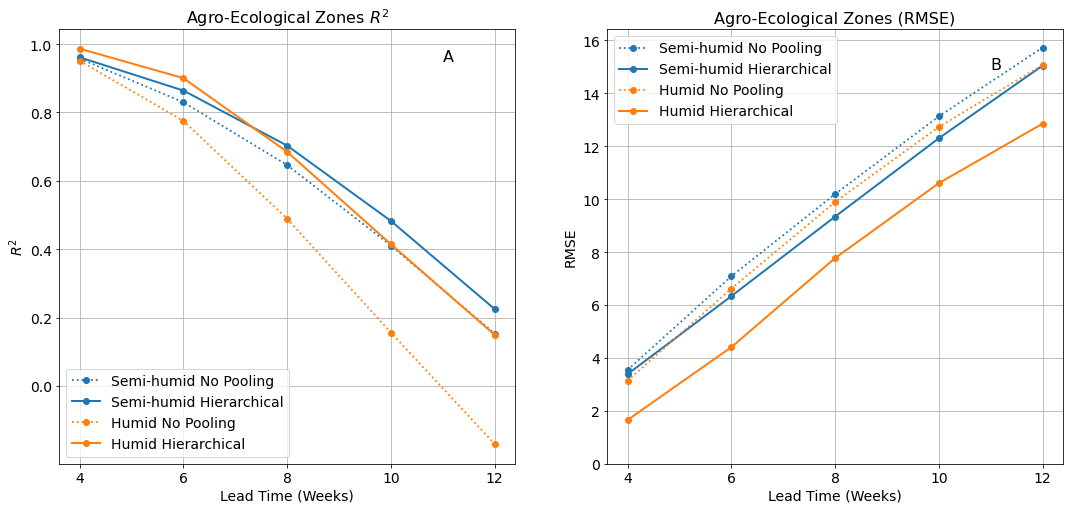

In [569]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#b516a5']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
for a, ax in enumerate(axs.reshape(-1)):
    m = ['R2','RMSE'][a]
    n = ['$R^2$','RMSE'][a]
    for i, z in enumerate(['Semi-Humid', 'Humid']):
        sub_lc1 = metricsUP[metricsUP.AEZ == z]
        sub_lc2 = metricsPP[metricsPP.AEZ == z]
        ax.plot(sub_lc1['Hor'], sub_lc1[m], label=f'{z.capitalize()} No Pooling',ls=':', color=colors[i], lw=1.8, marker='o')
        ax.plot(sub_lc2['Hor'], sub_lc2[m], label=f'{z.capitalize()} Hierarchical', lw=2, color=colors[i], marker='o')
    ax.set_ylabel(n, fontsize=14)
    ax.set_xticks(np.arange(4, 13, 2))
    ax.set_xticklabels(np.arange(4, 13, 2), fontsize=14)
    if m== 'R2':
        ax.set_yticks(np.arange(0, 1.2, 0.2))
        ax.set_yticklabels(np.round(np.arange(0, 1.2, 0.2),1), fontsize=14)
        ax.set_title('Agro-Ecological Zones $R^2$', fontsize=16)
        txt0 = ax.text(x=11.0, y=0.95, s='A', fontsize=16)
        ax.legend(loc='lower left', fontsize=14)
    ax.grid()
    ax.set_xlabel('Lead Time (Weeks)', fontsize=14)
    if m== 'RMSE':
        ax.set_yticks(np.arange(0,17, 2))
        ax.set_yticklabels(np.round(np.arange(0, 17, 2),1), fontsize=14)
        ax.set_title('Agro-Ecological Zones (RMSE)', fontsize=16)
        txt0 = ax.text(x=11.0, y=14.9, s='B', fontsize=16)
        ax.legend(loc='best', fontsize=14)
plt.savefig('R2_RMSE_AEZ3_Humid.pdf', bbox_inches='tight')

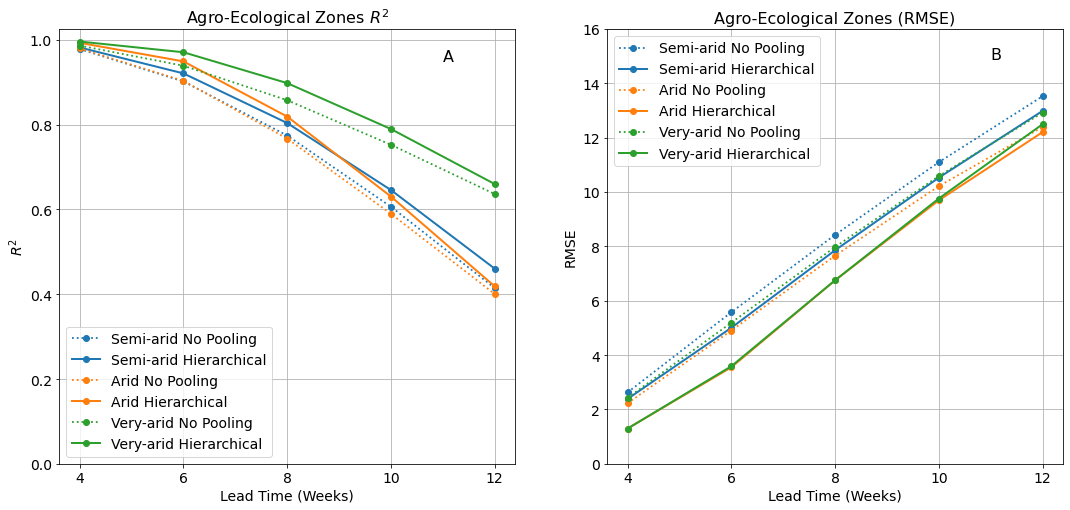

In [570]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#b516a5']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
for a, ax in enumerate(axs.reshape(-1)):
    m = ['R2','RMSE'][a]
    n = ['$R^2$','RMSE'][a]
    for i, z in enumerate(['Semi-Arid', 'Arid', 'Very-Arid']):
        sub_lc1 = metricsUP[metricsUP.AEZ == z]
        sub_lc2 = metricsPP[metricsPP.AEZ == z]
        ax.plot(sub_lc1['Hor'], sub_lc1[m], label=f'{z.capitalize()} No Pooling',ls=':', color=colors[i], lw=1.8, marker='o')
        ax.plot(sub_lc2['Hor'], sub_lc2[m], label=f'{z.capitalize()} Hierarchical', lw=2, color=colors[i], marker='o')
    ax.set_ylabel(n, fontsize=14)
    ax.set_xticks(np.arange(4, 13, 2))
    ax.set_xticklabels(np.arange(4, 13, 2), fontsize=14)
    if m== 'R2':
        ax.set_yticks(np.arange(0, 1.2, 0.2))
        ax.set_yticklabels(np.round(np.arange(0, 1.2, 0.2),1), fontsize=14)
        ax.set_title('Agro-Ecological Zones $R^2$', fontsize=16)
        txt0 = ax.text(x=11.0, y=0.95, s='A', fontsize=16)
        ax.legend(loc='lower left', fontsize=14)
    ax.grid()
    ax.set_xlabel('Lead Time (Weeks)', fontsize=14)
    if m== 'RMSE':
        ax.set_yticks(np.arange(0,17, 2))
        ax.set_yticklabels(np.round(np.arange(0, 17, 2),1), fontsize=14)
        ax.set_title('Agro-Ecological Zones (RMSE)', fontsize=16)
        txt0 = ax.text(x=11.0, y=14.9, s='B', fontsize=16)
        ax.legend(loc='best', fontsize=14)
plt.savefig('R2_RMSE_AEZ3_All.pdf', bbox_inches='tight')

<AxesSubplot:xlabel='FC_Type,AEZ'>

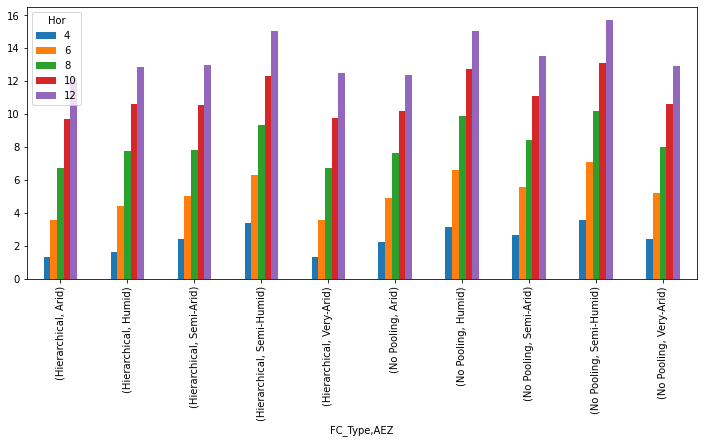

In [566]:
all_metrics.pivot_table(columns=['Hor'], values=['R2','RMSE'], index=['FC_Type','AEZ']).round(2).to_csv('AEZ_Metrics.csv')
all_metrics.pivot_table(columns=['Hor'], values=['R2','RMSE'], index=['FC_Type','AEZ']).round(2)['RMSE'].plot(kind='bar', figsize=(12, 5))

<AxesSubplot:xlabel='FC_Type,AEZ'>

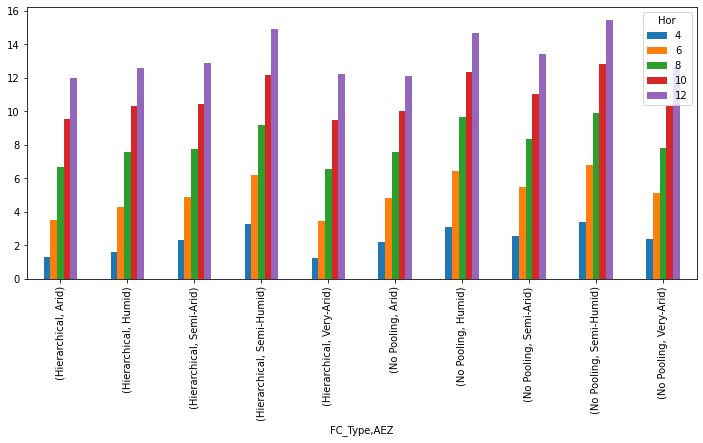

In [567]:
pall_metrics.pivot_table(columns=['Hor'], values=['R2','RMSE'], index=['FC_Type','AEZ']).round(2)['RMSE'].plot(kind='bar', figsize=(12, 5))

### METRICS FOR MAM AND OND SEASONS

In [124]:
UnPool_dfSSN = addSeason(UnPool_df)
PartPoolTrSSN = addSeason(PartPoolTr)

UnPool_dfMAM = UnPool_dfSSN[UnPool_dfSSN.Season=='mam']
UnPool_dfOND = UnPool_dfSSN[UnPool_dfSSN.Season=='ond']

PartPoolTrMAM = PartPoolTrSSN[PartPoolTrSSN.Season=='mam']
PartPoolTrOND = PartPoolTrSSN[PartPoolTrSSN.Season=='ond']

In [7]:
metricsUPMAM = plotContours(df=UnPool_dfMAM, sub_groups='AEZ', model_type='No Pooling', agg='all_county')
metricsPPMAM = plotContours(df=PartPoolTrMAM, sub_groups='AEZ', model_type='Hierarchical', agg='all_county')

metricsUPOND = plotContours(df=UnPool_dfOND, sub_groups='AEZ', model_type='No Pooling', agg='all_county')
metricsPPOND = plotContours(df=PartPoolTrOND, sub_groups='AEZ', model_type='Hierarchical', agg='all_county')

NameError: name 'plotContours' is not defined

### R2 AND RMSE PLOT FOR MAM AND OND SEASONS

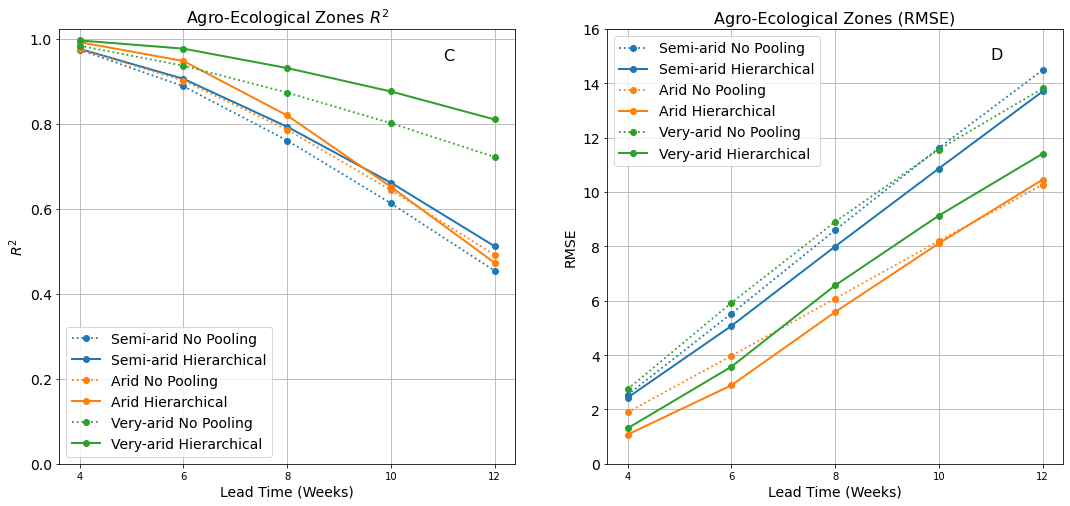

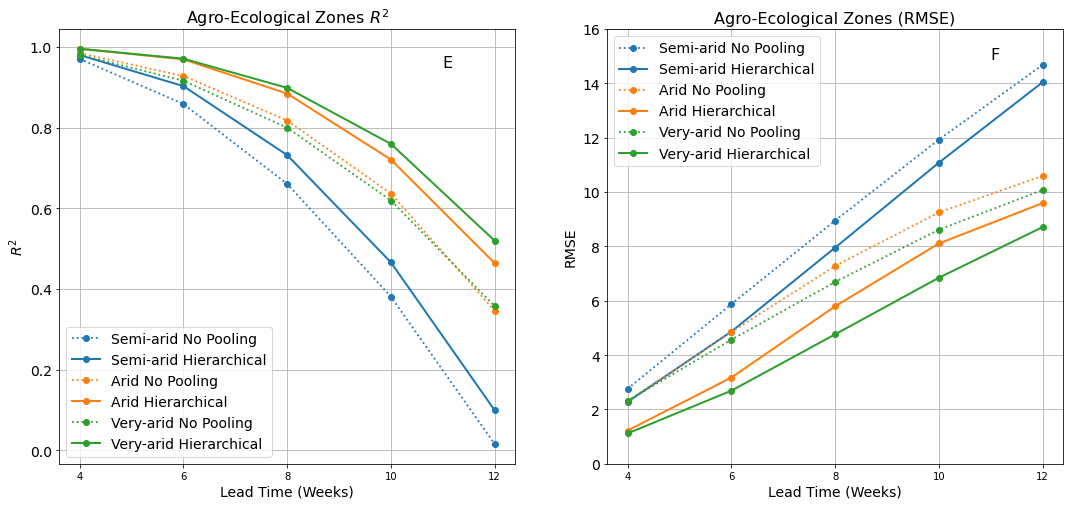

In [401]:

colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#b516a5']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
for a, ax in enumerate(axs.reshape(-1)):
    m = ['R2','RMSE'][a]
    n = ['$R^2$','RMSE'][a]
    for i, z in enumerate(['Semi-Arid', 'Arid', 'Very-Arid']):
        sub_lc1 = metricsUPMAM[metricsUPMAM.AEZ == z]
        sub_lc2 = metricsPPMAM[metricsPPMAM.AEZ == z]
        ax.plot(sub_lc1['Hor'], sub_lc1[m], label=f'{z.capitalize()} No Pooling',ls=':', color=colors[i], lw=1.8, marker='o')
        ax.plot(sub_lc2['Hor'], sub_lc2[m], label=f'{z.capitalize()} Hierarchical', lw=2, color=colors[i], marker='o')
    ax.set_ylabel(n, fontsize=14)
    ax.set_xticks(np.arange(4, 13, 2))
    if m== 'R2':
        ax.set_yticks(np.arange(0, 1.2, 0.2))
        ax.set_yticklabels(np.round(np.arange(0, 1.2, 0.2),1), fontsize=14)
        ax.set_title('Agro-Ecological Zones $R^2$', fontsize=16)
        txt0 = ax.text(x=11.0, y=0.95, s='C', fontsize=16)
        ax.legend(loc='lower left', fontsize=14)
    ax.grid()
    ax.set_xlabel('Lead Time (Weeks)', fontsize=14)
    if m== 'RMSE':
        ax.set_yticks(np.arange(0,17, 2))
        ax.set_yticklabels(np.round(np.arange(0, 17, 2),1), fontsize=14)
        ax.set_title('Agro-Ecological Zones (RMSE)', fontsize=16)
        txt0 = ax.text(x=11.0, y=14.9, s='D', fontsize=16)
        ax.legend(loc='best', fontsize=14)
plt.savefig('R2_RMSE_AEZ3_MAM.pdf', bbox_inches='tight')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#b516a5']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
for a, ax in enumerate(axs.reshape(-1)):
    m = ['R2','RMSE'][a]
    n = ['$R^2$','RMSE'][a]
    for i, z in enumerate(['Semi-Arid', 'Arid', 'Very-Arid']):
        sub_lc1 = metricsUPOND[metricsUPOND.AEZ == z]
        sub_lc2 = metricsPPOND[metricsPPOND.AEZ == z]
        ax.plot(sub_lc1['Hor'], sub_lc1[m], label=f'{z.capitalize()} No Pooling',ls=':', color=colors[i], lw=1.8, marker='o')
        ax.plot(sub_lc2['Hor'], sub_lc2[m], label=f'{z.capitalize()} Hierarchical', lw=2, color=colors[i], marker='o')
    ax.set_ylabel(n, fontsize=14)
    ax.set_xticks(np.arange(4, 13, 2))
    if m== 'R2':
        ax.set_yticks(np.arange(0, 1.2, 0.2))
        ax.set_yticklabels(np.round(np.arange(0, 1.2, 0.2),1), fontsize=14)
        ax.set_title('Agro-Ecological Zones $R^2$', fontsize=16)
        txt0 = ax.text(x=11.0, y=0.95, s='E', fontsize=16)
        ax.legend(loc='lower left', fontsize=14)
    ax.grid()
    ax.set_xlabel('Lead Time (Weeks)', fontsize=14)
    if m== 'RMSE':
        ax.set_yticks(np.arange(0,17, 2))
        ax.set_yticklabels(np.round(np.arange(0, 17, 2),1), fontsize=14)
        ax.set_title('Agro-Ecological Zones (RMSE)', fontsize=16)
        txt0 = ax.text(x=11.0, y=14.9, s='F', fontsize=16)
        ax.legend(loc='best', fontsize=14)
plt.savefig('R2_RMSE_AEZ3_OND.pdf', bbox_inches='tight')

### PLOT FOR TRANSFER LEARNING

In [8]:
metricsPPTrans = plotContours(df=PartPoolTran, sub_groups='AEZ', model_type='Hierarchical', agg='all_county')

NameError: name 'plotContours' is not defined

### R2 AND RMSE FOR TRANSFER LEARNING

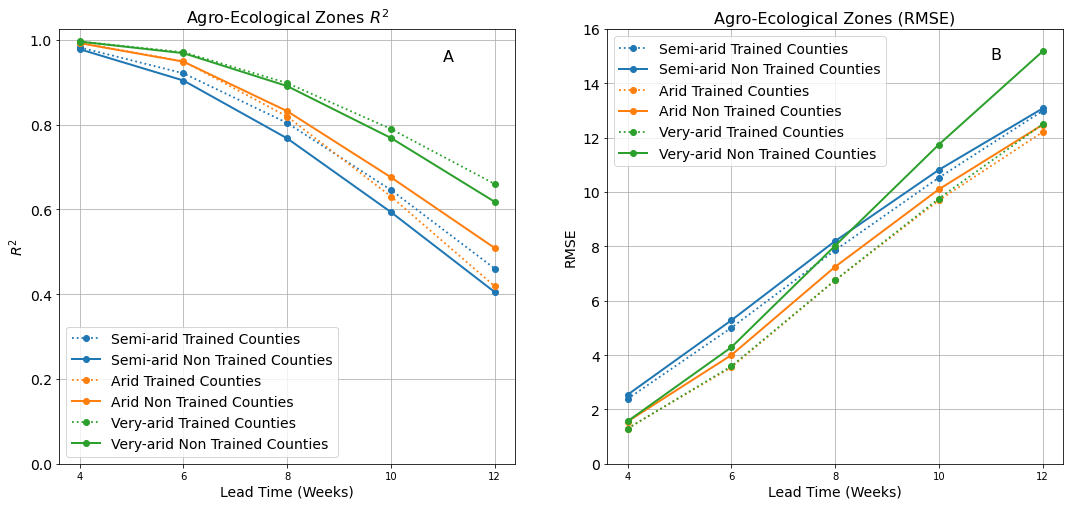

In [532]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#b516a5']
tc_aez = metricsPP
ntc_aez = metricsPPTrans
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
for a, ax in enumerate(axs.reshape(-1)):
    m = ['R2','RMSE'][a]
    n = ['$R^2$','RMSE'][a]
    for i, z in enumerate(['Semi-Arid', 'Arid', 'Very-Arid']):
        sub_lc1 = tc_aez[tc_aez.AEZ == z]
        sub_lc2 = ntc_aez[ntc_aez.AEZ == z]
        ax.plot(sub_lc1['Hor'], sub_lc1[m], label=f'{z.capitalize()} Trained Counties',ls=':', color=colors[i], lw=1.8, marker='o')
        ax.plot(sub_lc2['Hor'], sub_lc2[m], label=f'{z.capitalize()} Non Trained Counties', lw=2, color=colors[i], marker='o')
    ax.set_ylabel(n, fontsize=14)
    ax.set_xticks(np.arange(4, 13, 2))
    if m== 'R2':
        ax.set_yticks(np.arange(0, 1.2, 0.2))
        ax.set_yticklabels(np.round(np.arange(0, 1.2, 0.2),1), fontsize=14)
        ax.set_title('Agro-Ecological Zones $R^2$', fontsize=16)
        txt0 = ax.text(x=11.0, y=0.95, s='A', fontsize=16)
        ax.legend(loc='lower left', fontsize=14)
    ax.grid()
    ax.set_xlabel('Lead Time (Weeks)', fontsize=14)
    if m== 'RMSE':
        ax.set_yticks(np.arange(0,17, 2))
        ax.set_yticklabels(np.round(np.arange(0, 17, 2),1), fontsize=14)
        ax.set_title('Agro-Ecological Zones (RMSE)', fontsize=16)
        txt0 = ax.text(x=11.0, y=14.9, s='B', fontsize=16)
        ax.legend(loc='best', fontsize=14)
plt.savefig('Trans_RMSE_AEZ3.pdf', bbox_inches='tight')

### PLOT ROC CURVES

4350
[99.22216387]
317 13 33 531
[99.22216387 96.45412896]
317 13 33 531
[99.22216387 96.45412896 92.40518883]
317 13 33 531
[99.22216387 96.45412896 92.40518883 85.70009333]
317 13 33 531
[99.22216387 96.45412896 92.40518883 85.70009333 74.93089431]
317 13 33 531
3625
[99.44345147]
378 6 28 333
[99.44345147 97.13318369]
378 6 28 333
[99.44345147 97.13318369 93.23898402]
378 6 28 333
[99.44345147 97.13318369 93.23898402 88.32962331]
378 6 28 333
[99.44345147 97.13318369 93.23898402 88.32962331 81.10965296]
378 6 28 333
2900
[99.61911026]
213 7 13 363
[99.61911026 98.1505094 ]
213 7 13 363
[99.61911026 98.1505094  95.12792633]
213 7 13 363
[99.61911026 98.1505094  95.12792633 91.65887188]
213 7 13 363
[99.61911026 98.1505094  95.12792633 91.65887188 88.65777439]
213 7 13 363


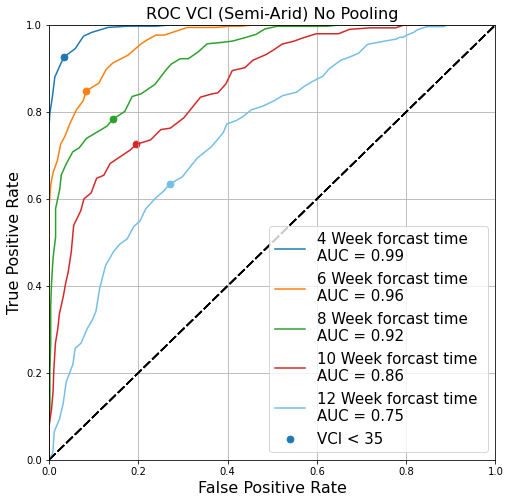

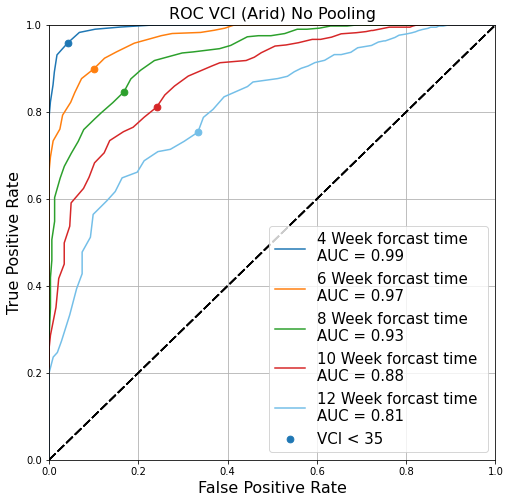

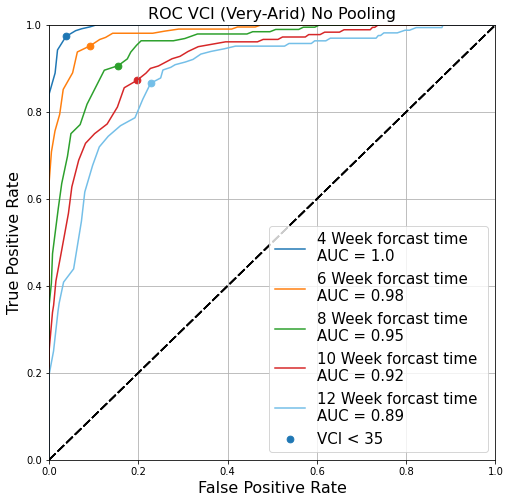

In [117]:
# UNPOOLED
for x in ['Semi-Arid','Arid','Very-Arid']:
    subaez = UnPool_df[UnPool_df.AEZ==x]
    print(len(subaez))
    plotROC(subaez,f'VCI ({x}) No Pooling', 'VCI')

4350
[99.34045833]
539 355
[99.34045833 98.02364181]
537 345
[99.34045833 98.02364181 93.92547461]
539 331
[99.34045833 98.02364181 93.92547461 88.78114486]
541 317
[99.34045833 98.02364181 93.92547461 88.78114486 81.16422466]
546 300
3625
[99.80217606]
337 408
[99.80217606 98.96068213]
334 401
[99.80217606 98.96068213 96.07678437]
322 403
[99.80217606 98.96068213 96.07678437 90.45857988]
312 403
[99.80217606 98.96068213 96.07678437 90.45857988 83.1680443 ]
302 403
2900
[99.82738032]
363 233
[99.82738032 98.89288371]
370 218
[99.82738032 98.89288371 95.69451055]
382 198
[99.82738032 98.89288371 95.69451055 92.09492973]
382 190
[99.82738032 98.89288371 95.69451055 92.09492973 86.46112805]
400 164


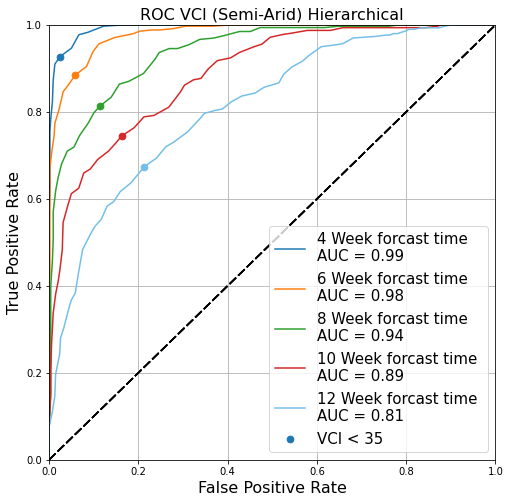

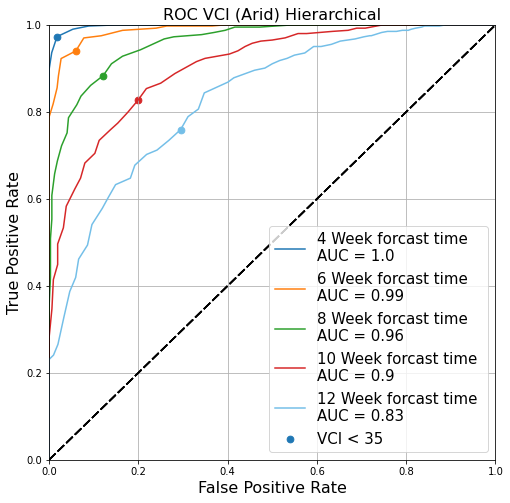

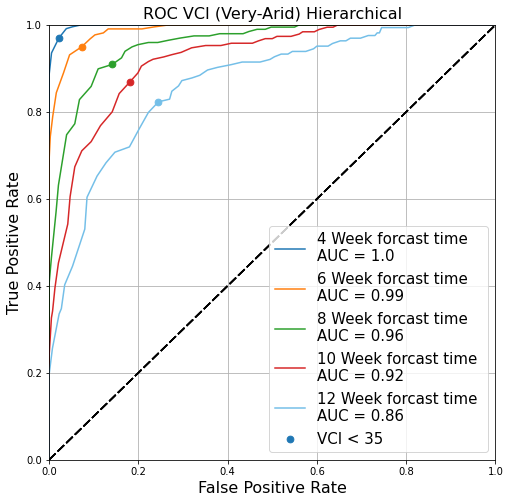

In [102]:
# PARTIAL POOLED
for x in ['Semi-Arid','Arid','Very-Arid']:
    subaez1 = PartPoolTr[PartPoolTr.AEZ==x]
    print(len(subaez1))
    plotROC(subaez1,f'VCI ({x}) Hierarchical', 'VCI')

### GET ROC CURVE OUTPUTS FOR MAKING COMBINED PLOTS 

In [103]:
roc_filesNP = glob.glob('ROC_Metrics_VCI*No Pooling*csv')
roc_filesHM = glob.glob('ROC_Metrics_VCI*Hierarchical*csv')
roc_filesNP+roc_filesHM

['ROC_Metrics_VCI (Very-Arid) No Pooling_8.csv',
 'ROC_Metrics_VCI (Semi-Arid) No Pooling_12.csv',
 'ROC_Metrics_VCI (Arid) No Pooling_8.csv',
 'ROC_Metrics_VCI (Semi-Arid) No Pooling_10.csv',
 'ROC_Metrics_VCI (Arid) No Pooling_12.csv',
 'ROC_Metrics_VCI (Arid) No Pooling_10.csv',
 'ROC_Metrics_VCI (Semi-Arid) No Pooling_8.csv',
 'ROC_Metrics_VCI (Semi-Arid) No Pooling_6.csv',
 'ROC_Metrics_VCI (Semi-Arid) No Pooling_4.csv',
 'ROC_Metrics_VCI (Arid) No Pooling_4.csv',
 'ROC_Metrics_VCI (Very-Arid) No Pooling_6.csv',
 'ROC_Metrics_VCI (Very-Arid) No Pooling_4.csv',
 'ROC_Metrics_VCI (Arid) No Pooling_6.csv',
 'ROC_Metrics_VCI (Very-Arid) No Pooling_10.csv',
 'ROC_Metrics_VCI (Very-Arid) No Pooling_12.csv',
 'ROC_Metrics_VCI (Semi-Arid) Hierarchical_4.csv',
 'ROC_Metrics_VCI (Arid) Hierarchical_12.csv',
 'ROC_Metrics_VCI (Arid) Hierarchical_10.csv',
 'ROC_Metrics_VCI (Semi-Arid) Hierarchical_6.csv',
 'ROC_Metrics_VCI (Arid) Hierarchical_8.csv',
 'ROC_Metrics_VCI (Very-Arid) Hierarchical

In [104]:
def joinROC(files):
    df_ls = []
    for f in files:
        hor = f.split(')')[1].split('_')[1][:-4]
        model = f.split(')')[1].split('_')[0][1:]
        lc = f.split(' ')[1][1:-1]
        df = pd.read_csv(f)
        df['Threshold'] = df.index
        df['Horizon'] = np.repeat(int(hor), len(df))
        df['Model'] = np.repeat(model, len(df))
        df['Zone'] = np.repeat(lc, len(df))
        
        df_ls.append(df)
    return pd.concat(df_ls)

In [105]:
roc_df = joinROC(roc_filesNP+roc_filesHM)

In [106]:
roc_df2 = roc_df[roc_df.Model=='No Pooling']
roc_df3 = roc_df[roc_df.Model=='Hierarchical']

### MAKE COMBINED PLOTS 

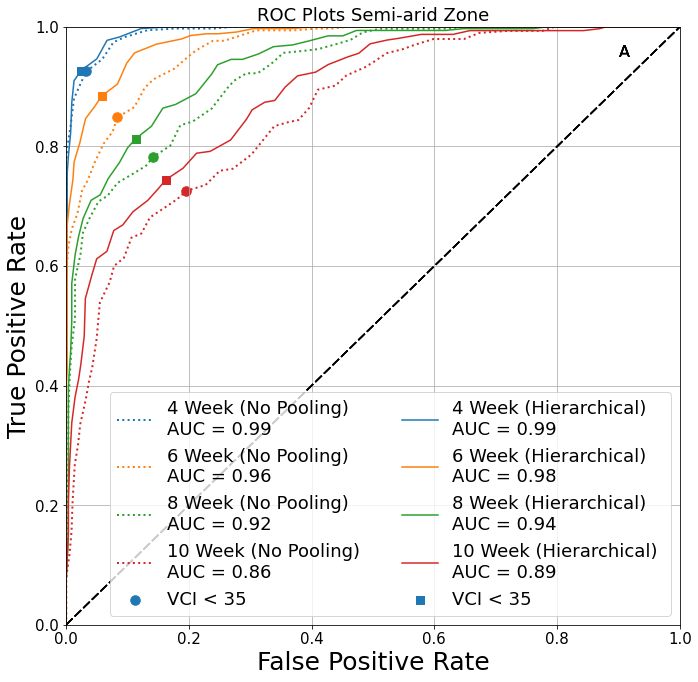

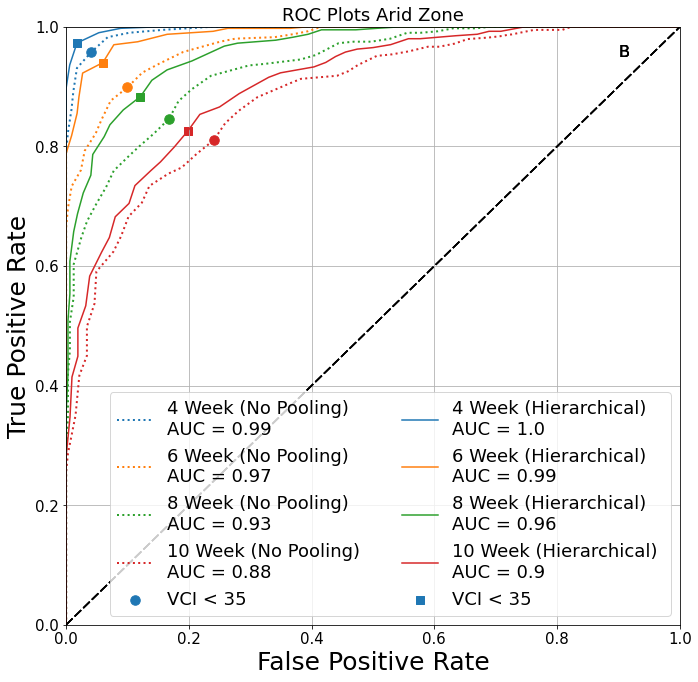

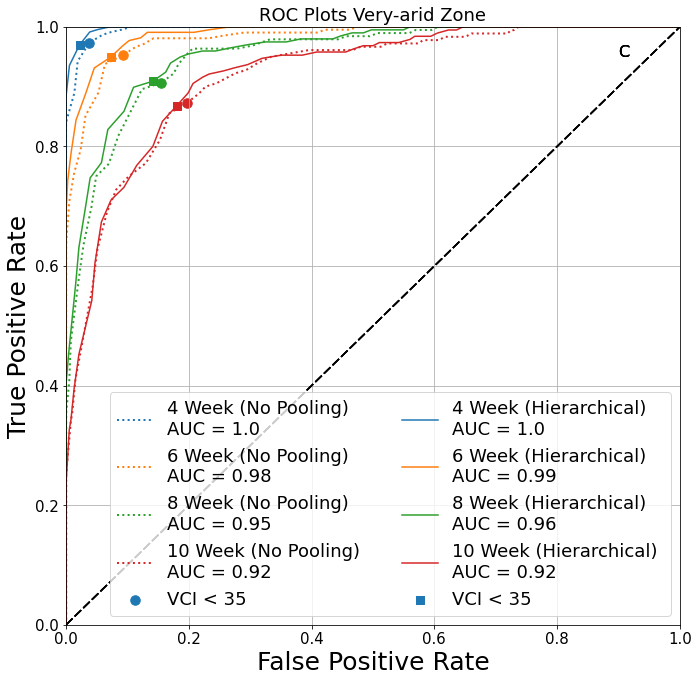

In [119]:
for l, a in zip(['Semi-Arid','Arid','Very-Arid'], ['A','B','C']):
    plt.figure(figsize=(11,11))
    for i, h in enumerate([4,6,8,10]):
        sub_0 = roc_df2[(roc_df2.Zone==l)&(roc_df2.Horizon==h)]
        sub_1 = roc_df3[(roc_df3.Zone==l)&(roc_df3.Horizon==h)]

        AUC0 = np.trapz(sub_0.TPR,sub_0.FPR,dx=0.001)
        AUC1 = np.trapz(sub_1.TPR,sub_1.FPR,dx=0.001)


        plt.plot(sub_0.FPR, sub_0.TPR, ls=':',lw=2, color=colors[i], label=f'{h} Week (No Pooling) \nAUC = {round(AUC0,2)}')
        plt.plot(sub_1.FPR, sub_1.TPR, ls='-',color=colors[i],label=f'{h} Week (Hierarchical) \nAUC = {round(AUC1,2)}')

        plt.scatter(sub_0[sub_0.Threshold==35].FPR, sub_0[sub_0.Threshold==35].TPR,s=90, marker='o', color=colors[i], label = ('VCI < 35')) 
        plt.scatter(sub_1[sub_1.Threshold==35].FPR, sub_1[sub_1.Threshold==35].TPR,s=60,  marker='s', color=colors[i], label = ('VCI < 35'))

        yx = np.linspace(0,1,10)
        plt.plot(yx,yx, dashes=[6, 2],color='black')

        plt.title(f'ROC Plots {l.capitalize()} Zone', fontsize=18)
        plt.xlim(0,1)
        plt.ylim(0,1)
    #     plt.legend(fontsize=13)
        plt.grid(True)
        plt.ylabel('True Positive Rate', fontsize=25)
        plt.xlabel('False Positive Rate', fontsize=25)
        plt.yticks(fontsize=15)
        plt.xticks( fontsize=15)
        plt.text(x=0.9, y=0.95, s=a, fontsize=16)
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0,2,4,6,8,1,3,5,7,9]
    plt.legend([handles[o] for o in order],[labels[o] for o in order], ncol=2, loc='lower right', fontsize=18)
#     plt.savefig(f'{l}_Joint_ROC_Plots3.pdf', dpi=300, bbox_inches='tight')

In [120]:
th35 = []
for i in [4,6,8,10,12]:
    sub_th = roc_df[roc_df.Horizon==i]
    sub_th2 = sub_th[sub_th.Threshold==34]
    sub_th3 = sub_th2[sub_th2.Zone.isin(['Semi-Arid','Arid','Very-Arid'])]
    th35.append(sub_th3)
th350= pd.concat(th35)

In [121]:
piv350 = th350.pivot_table(index=['Model','Zone'], columns=['Horizon'], values=['TPR', 'FPR'])
piv350

FPR                                          \
Horizon                       4         6         8         10        12   
Model        Zone                                                          
Hierarchical Arid       0.005935  0.026946  0.093168  0.176282  0.268212   
             Semi-Arid  0.012987  0.046555  0.100186  0.149723  0.199634   
             Very-Arid  0.005510  0.045946  0.109948  0.157068  0.222500   
No Pooling   Arid       0.017699  0.072727  0.142857  0.212963  0.302469   
             Semi-Arid  0.023897  0.076067  0.129562  0.181172  0.256667   
             Very-Arid  0.018919  0.063325  0.123711  0.168367  0.210000   

                             TPR                                          
Horizon                       4         6         8         10        12  
Model        Zone                                                         
Hierarchical Arid       0.936275  0.922693  0.861042  0.799007  0.734491  
             Semi-Arid  0.909859  0.866667  0.797583  0.728707  0.656667  
             Very-Arid  0.935622  0.931193  0.898990  0.842105  0.798780  
No Pooling   Arid       0.931034  0.876543  0.821340  0.787724  0.732283  
             Semi-Arid  0.905714  0.825073  0.767081  0.711864  0.617886  
             Very-Arid  0.942478  0.937799  0.895833  0.855556  0.829268

In [122]:
piv350.columns = [f'{a}_{b}' for a, b in piv350.columns]
tpr = [c for c in piv350.columns if 'TPR' in c ]
far = [c for c in piv350.columns if 'FPR' in c ]

roc_dict = pd.DataFrame()
for i, w in zip(tpr, far):
    c  = piv350.index
    n = piv350[i].values*100
    m = piv350[w].values*100
    roc_dict['Zone'] = [f'{t[0]} {t[1].capitalize()}' for t in c] 
    roc_dict[i]=[f'{int(v.round(0))} ({int(u.round(0))})' for v, u in zip(n, m)]

In [123]:
roc_dict

,Zone,TPR_4,TPR_6,TPR_8,TPR_10,TPR_12
0,Hierarchical Arid,94 (1),92 (3),86 (9),80 (18),73 (27)
1,Hierarchical Semi-arid,91 (1),87 (5),80 (10),73 (15),66 (20)
2,Hierarchical Very-arid,94 (1),93 (5),90 (11),84 (16),80 (22)
3,No Pooling Arid,93 (2),88 (7),82 (14),79 (21),73 (30)
4,No Pooling Semi-arid,91 (2),83 (8),77 (13),71 (18),62 (26)
5,No Pooling Very-arid,94 (2),94 (6),90 (12),86 (17),83 (21)


In [267]:
subaez = allPreds[allPreds.AEZ=='Very-Arid']
freqs_out = getFreqs1(subaez,'FNo-Drought','Obs_No-Drought', 0.1)

### PLOT RELIABILITY DIAGRAMS 

In [9]:
freq_ls = []
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#b516a5']
for x in aezs[2:]:
    subaez = allPreds[allPreds.AEZ==x]
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))
    for a, ax in enumerate(axs.reshape(-1)):
        cols = (['FNo-Drought', 'Obs_No-Drought'],['FDrought','Obs_Drought'])[a]
        freqs_out = getFreqs1(subaez, cols[0], cols[1], 0.2)
        bss = []
        print(cols)
        for i, h in enumerate([4,6,8,10,12]):
            sub_step = freqs_out[freqs_out['Horizon']==h]
            sub_data = subaez[subaez['Horizon']==h]
            sub_step['Threshold'] = f'{cols[1][4:]}'
            freq_ls.append(sub_step)
            brier_score = brier_score_loss(sub_data[cols[1]], sub_data[cols[0]], pos_label=1)
            bss.append(brier_score)
            ax.plot((0,1), (0,1), 'k--', lw=2.5 , color='black')
            ax.set_title(f'{cols[1][4:]} Event | {x}', fontsize=16)
            ax.plot(sub_step.FcastProbs, sub_step.Obs_Freq, marker='o', lw=1, color=colors[i], label=f'{h} weeks ahead')
            ax.set_ylabel("Observed Relative Frequency", fontsize=13)
            ax.set_xlabel("Forecast Probality", fontsize=13)
            ax.set_ylim([0, 1.01])
            ax.set_xlim([0, 1.01])
            ax.grid(True)
            ax.legend(loc='lower right', fontsize=12)
            axins = inset_axes(ax, width="80%", height="40%",
                           bbox_to_anchor=(0.08, 0.58, .5, .4),
                           bbox_transform=ax.transAxes, loc=2, borderpad=0)
            axins.tick_params(left=True, right=False, labelleft=True, labelright=False)
            axins.plot(sub_step.FcastProbs, np.log(sub_step.Fcastfreqs), color=colors[i], marker='o')
            if h != 12:
                axins.set_yticks([])
                axins.set_xticks([])
            else:
                axins.set_yticks(np.arange(2, 9, 2))
                axins.set_xticks(np.arange(0, 1.1, 0.2))
                axins.set_ylabel('$Log_{10}$ Samples')
        txt = ax.text(x=0.23, y=0.03, s=f'Brier Score 4 Week: {bss[0].round(3)}\nBrier Score 6 Week: {bss[1].round(3)}\nBrier Score 8 Week: {bss[2].round(3)}\nBrier Score 10 Week: {bss[3].round(3)}\nBrier Score 12 Week: {bss[4].round(3)}', fontsize=12)
        txt.set_bbox(dict(facecolor='white', alpha=0.6))
        plt.savefig(f'Reliability_Plot_{x}_weeks3.png', bbox_inches='tight', transparent=True)

NameError: name 'aezs' is not defined

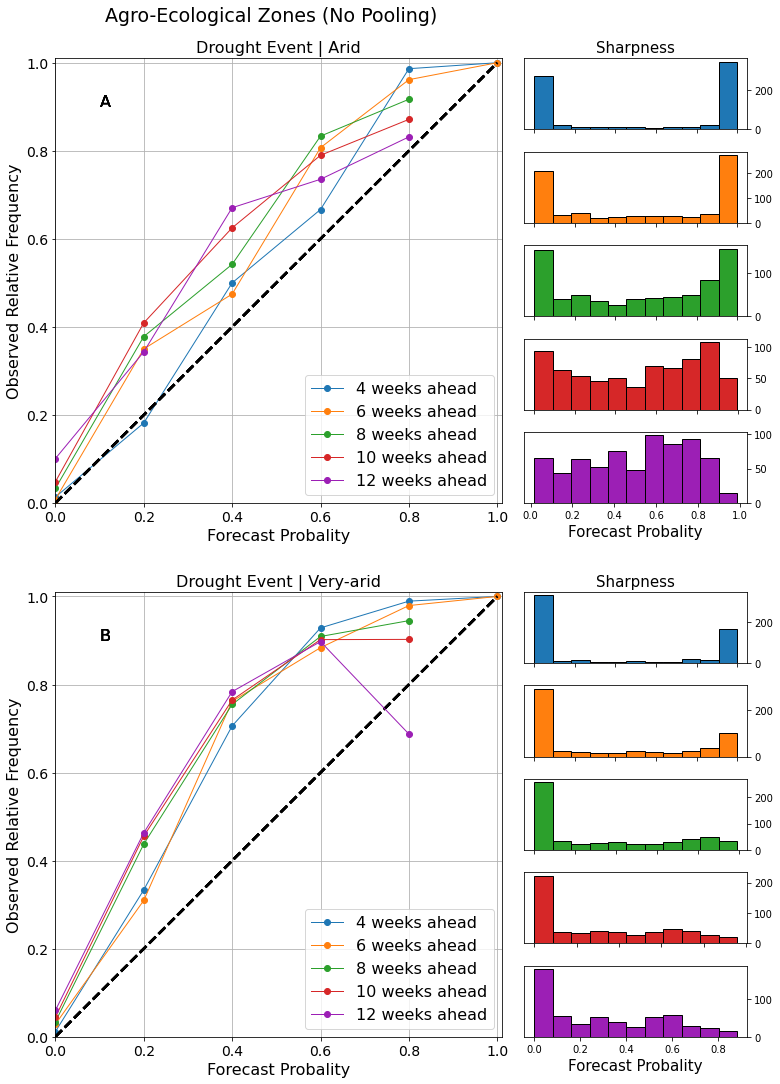

In [545]:
freq_ls = []
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9c1fb5']

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 18))
fig.suptitle(f'Agro-Ecological Zones (No Pooling)', y=0.92, fontsize=19)
for a, ax in enumerate(axs.reshape(-1)):
    x = ['Arid','Very-Arid'][a]
    n = ['A','B'][a]
    subaez = UnPool_df[UnPool_df.AEZ==x]
    freqs_out = getFreqs1(subaez,'FDrought','Obs_Drought', 0.2)
    bss = []
    for i, h in enumerate([4,6,8,10,12]):
        p = [.6,.39,.18,-.03,-.24][i]
        sub_step = freqs_out[freqs_out['Horizon']==h]
        sub_data = subaez[subaez['Horizon']==h]
        sub_step['Threshold'] = 'Drought'
        sub_step['AEZ'] = x
        freq_ls.append(sub_step)
#         brier_score = brier_score_loss(sub_data['Obs_Drought'], sub_data['FDrought'], pos_label=1)
#         bss.append(brier_score)
        ax.plot((0,1), (0,1), 'k--', lw=2.5 , color='black')
        ax.set_title(f'Drought Event | {x.capitalize()}', fontsize=16)
        ax.plot(sub_step.FcastProbs, sub_step.Obs_Freq, marker='o', lw=1, color=colors[i], label=f'{h} weeks ahead')
        ax.set_ylabel("Observed Relative Frequency", fontsize=16)
        ax.set_xlabel("Forecast Probality", fontsize=16)
        ax.set_ylim([0, 1.01])
        ax.set_xlim([0, 1.01])
        ax.grid(True)
        ax.text(x=0.1, y=0.9, s=n, fontsize=16)
        ax.set_yticks(np.arange(0, 1.2, 0.2))
        ax.set_yticklabels(np.round(np.arange(0, 1.2, 0.2),1), fontsize=14)
        ax.set_xticks(np.arange(0, 1.2, 0.2))
        ax.set_xticklabels(np.round(np.arange(0, 1.2, 0.2),1), fontsize=14)
        ax.legend(loc='lower right', fontsize=16)
        axins = inset_axes(ax, width="100%", height="40%",
                           bbox_to_anchor=(1.05, p, .5, .4),
                           bbox_transform=ax.transAxes, loc=2, borderpad=0)
        if h in [4,6,8,10]:
            axins.tick_params(left=False, right=True, labelleft=False, labelright=True, labelbottom=False)
        if h == 4:
            axins.set_title(f'Sharpness',fontsize=15),
        if h == 12:
            axins.tick_params(left=False, right=True, labelleft=False, labelright=True)
            axins.set_xlabel("Forecast Probality", fontsize=15),
        axins.hist(sub_data.FDrought.values, color=colors[i], bins=11, ec="k")
        
# plt.savefig(f'../Reliability_Plot_LC3.png', bbox_inches='tight')
plt.savefig(f'NoPool_Reliability_Plot_AEZ3.pdf', bbox_inches='tight')

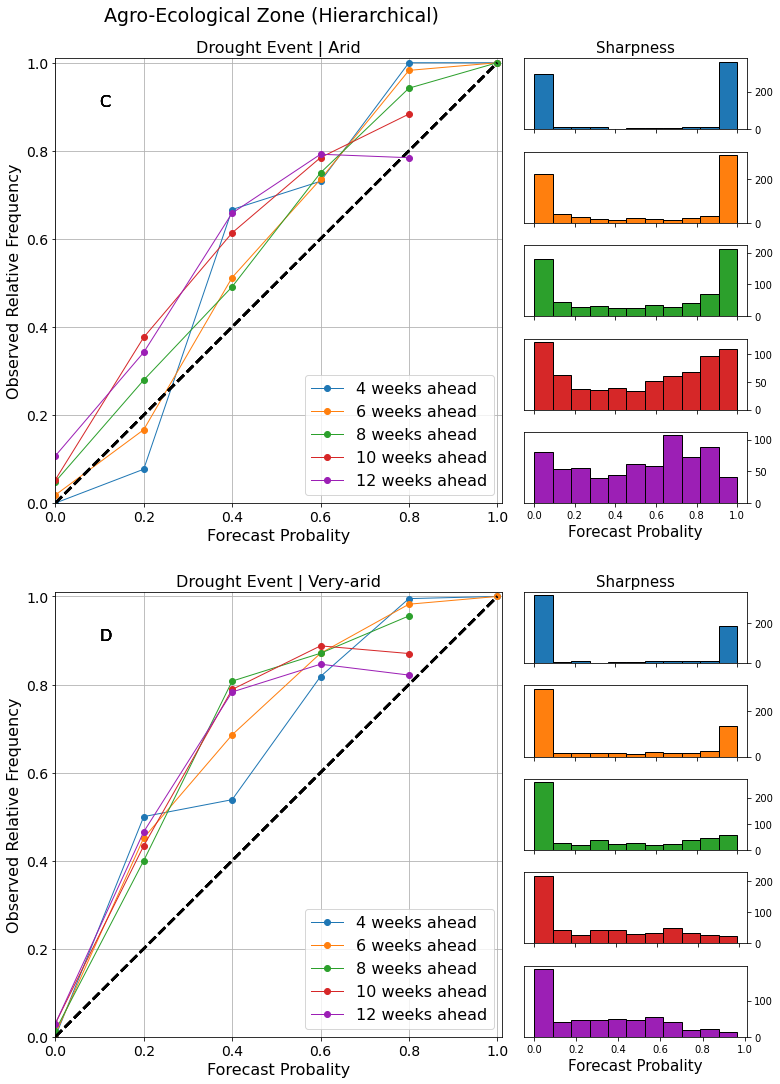

In [547]:
freq_ls = []
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9c1fb5']

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 18))
fig.suptitle(f'Agro-Ecological Zone (Hierarchical)', y=.92, fontsize=19)
for a, ax in enumerate(axs.reshape(-1)):
    x =  ['Arid','Very-Arid'][a]
    n = ['C','D'][a]
    subaez = PartPoolTr[PartPoolTr.AEZ==x]
    freqs_out = getFreqs1(subaez,'FDrought','Obs_Drought', 0.2)
    bss = []
    for i, h in enumerate([4,6,8,10,12]):
        p = [.6,.39,.18,-.03,-.24][i]
        sub_step = freqs_out[freqs_out['Horizon']==h]
        sub_data = subaez[subaez['Horizon']==h]
        sub_step['Threshold'] = 'Drought'
        sub_step['AEZ'] = x
        freq_ls.append(sub_step)
#         brier_score = brier_score_loss(sub_data['Obs_Drought'], sub_data['FDrought'], pos_label=1)
#         bss.append(brier_score)
        ax.plot((0,1), (0,1), 'k--', lw=2.5 , color='black')
        ax.set_title(f'Drought Event | {x.capitalize()}', fontsize=16)
        ax.plot(sub_step.FcastProbs, sub_step.Obs_Freq, marker='o', lw=1, color=colors[i], label=f'{h} weeks ahead')
        ax.set_ylabel("Observed Relative Frequency", fontsize=16)
        ax.set_xlabel("Forecast Probality", fontsize=16)
        ax.set_ylim([0, 1.01])
        ax.set_xlim([0, 1.01])
        ax.grid(True)
        ax.text(x=0.1, y=0.9, s=n, fontsize=16)
        ax.set_yticks(np.arange(0, 1.2, 0.2))
        ax.set_yticklabels(np.round(np.arange(0, 1.2, 0.2),1), fontsize=14)
        ax.set_xticks(np.arange(0, 1.2, 0.2))
        ax.set_xticklabels(np.round(np.arange(0, 1.2, 0.2),1), fontsize=14)
        ax.legend(loc='lower right', fontsize=16)
        axins = inset_axes(ax, width="100%", height="40%",
                           bbox_to_anchor=(1.05, p, .5, .4),
                           bbox_transform=ax.transAxes, loc=2, borderpad=0)
        if h in [4,6,8,10]:
            axins.tick_params(left=False, right=True, labelleft=False, labelright=True, labelbottom=False)
        if h == 4:
            axins.set_title(f'Sharpness',fontsize=15),
        if h == 12:
            axins.tick_params(left=False, right=True, labelleft=False, labelright=True)
            axins.set_xlabel("Forecast Probality", fontsize=15),
        axins.hist(sub_data.FDrought.values, color=colors[i], bins=11, ec="k")
        
# plt.savefig(f'Reliability_Plot_AEZ3.pdf', bbox_inches='tight')
plt.savefig(f'Hierarchical_Reliability_PlotAEZ3.pdf', bbox_inches='tight')

In [10]:
freq_ls = []
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9c1fb5']

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 30))
fig.suptitle(f'Agro-Ecological Zone (No Pooling) OND', y=0.9, fontsize=19)
for a, ax in enumerate(axs.reshape(-1)):
    x =  ['Semi-Arid','Arid','Very-Arid'][a]
    subaez = UnPool_dfOND[UnPool_dfOND.AEZ==x]
    freqs_out = getFreqs1(subaez,'FDrought','Obs_Drought', 0.2)
    bss = []
    for i, h in enumerate([4,6,8,10,12]):
        p = [.6,.39,.18,-.03,-.24][i]
        sub_step = freqs_out[freqs_out['Horizon']==h]
        sub_data = subaez[subaez['Horizon']==h]
        sub_step['Threshold'] = 'Drought'
        sub_step['AEZ'] = x
        freq_ls.append(sub_step)
#         brier_score = brier_score_loss(sub_data['Obs_Drought'], sub_data['FDrought'], pos_label=1)
#         bss.append(brier_score)
        ax.plot((0,1), (0,1), 'k--', lw=2.5 , color='black')
        ax.set_title(f'Drought Event | {x.capitalize()}', fontsize=16)
        ax.plot(sub_step.FcastProbs, sub_step.Obs_Freq, marker='o', lw=1, color=colors[i], label=f'{h} weeks ahead')
        ax.set_ylabel("Observed Relative Frequency", fontsize=16)
        ax.set_xlabel("Forecast Probality", fontsize=16)
        ax.set_ylim([0, 1.01])
        ax.set_xlim([0, 1.01])
        ax.grid(True)
        ax.legend(loc='lower right', fontsize=16)
        axins = inset_axes(ax, width="100%", height="40%",
                           bbox_to_anchor=(1.05, p, .5, .4),
                           bbox_transform=ax.transAxes, loc=2, borderpad=0)
        if h in [4,6,8,10]:
            axins.tick_params(left=False, right=True, labelleft=False, labelright=True, labelbottom=False)
        if h == 4:
            axins.set_title(f'Sharpness',fontsize=15),
        if h == 12:
            axins.tick_params(left=False, right=True, labelleft=False, labelright=True)
            axins.set_xlabel("Forecast Probality", fontsize=15),
        axins.hist(sub_data.FDrought.values, color=colors[i], bins=11, ec="k")
        
# plt.savefig(f'../Reliability_Plot_LC3.png', bbox_inches='tight')
plt.savefig(f'Hierarchical_Reliability_Plot_AEZ3.pdf', bbox_inches='tight')

NameError: name 'plt' is not defined

In [11]:
freq_ls = []
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9c1fb5']

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 30))
fig.suptitle(f'Agro-Ecological Zone (Hierarchical) OND', y=0.9, fontsize=19)
for a, ax in enumerate(axs.reshape(-1)):
    x =  ['Semi-Arid','Arid','Very-Arid'][a]
    subaez = PartPoolTrOND[PartPoolTrOND.AEZ==x]
    freqs_out = getFreqs1(subaez,'FDrought','Obs_Drought', 0.2)
    bss = []
    for i, h in enumerate([4,6,8,10,12]):
        p = [.6,.39,.18,-.03,-.24][i]
        sub_step = freqs_out[freqs_out['Horizon']==h]
        sub_data = subaez[subaez['Horizon']==h]
        sub_step['Threshold'] = 'Drought'
        sub_step['AEZ'] = x
        freq_ls.append(sub_step)
#         brier_score = brier_score_loss(sub_data['Obs_Drought'], sub_data['FDrought'], pos_label=1)
#         bss.append(brier_score)
        ax.plot((0,1), (0,1), 'k--', lw=2.5 , color='black')
        ax.set_title(f'Drought Event | {x.capitalize()}', fontsize=16)
        ax.plot(sub_step.FcastProbs, sub_step.Obs_Freq, marker='o', lw=1, color=colors[i], label=f'{h} weeks ahead')
        ax.set_ylabel("Observed Relative Frequency", fontsize=16)
        ax.set_xlabel("Forecast Probality", fontsize=16)
        ax.set_ylim([0, 1.01])
        ax.set_xlim([0, 1.01])
        ax.grid(True)
        ax.legend(loc='lower right', fontsize=16)
        axins = inset_axes(ax, width="100%", height="40%",
                           bbox_to_anchor=(1.05, p, .5, .4),
                           bbox_transform=ax.transAxes, loc=2, borderpad=0)
        if h in [4,6,8,10]:
            axins.tick_params(left=False, right=True, labelleft=False, labelright=True, labelbottom=False)
        if h == 4:
            axins.set_title(f'Sharpness',fontsize=15),
        if h == 12:
            axins.tick_params(left=False, right=True, labelleft=False, labelright=True)
            axins.set_xlabel("Forecast Probality", fontsize=15),
        axins.hist(sub_data.FDrought.values, color=colors[i], bins=11, ec="k")
        
# plt.savefig(f'../Reliability_Plot_LC3.png', bbox_inches='tight')
# plt.savefig(f'../Hierarchical_Reliability_Plot_LC3.pdf', bbox_inches='tight')

NameError: name 'plt' is not defined

In [12]:
freq_ls = []
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9c1fb5']

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 30))
fig.suptitle(f'Agro-Ecological Zone (Hierarchical) OND', y=0.9, fontsize=19)
for a, ax in enumerate(axs.reshape(-1)):
    x =  ['Semi-Arid','Arid','Very-Arid'][a]
    subaez = PartPoolTrMAM[PartPoolTrMAM.AEZ==x]
    freqs_out = getFreqs1(subaez,'FDrought','Obs_Drought', 0.2)
    bss = []
    for i, h in enumerate([4,6,8,10,12]):
        p = [.6,.39,.18,-.03,-.24][i]
        sub_step = freqs_out[freqs_out['Horizon']==h]
        sub_data = subaez[subaez['Horizon']==h]
        sub_step['Threshold'] = 'Drought'
        sub_step['AEZ'] = x
        freq_ls.append(sub_step)
#         brier_score = brier_score_loss(sub_data['Obs_Drought'], sub_data['FDrought'], pos_label=1)
#         bss.append(brier_score)
        ax.plot((0,1), (0,1), 'k--', lw=2.5 , color='black')
        ax.set_title(f'Drought Event | {x.capitalize()}', fontsize=16)
        ax.plot(sub_step.FcastProbs, sub_step.Obs_Freq, marker='o', lw=1, color=colors[i], label=f'{h} weeks ahead')
        ax.set_ylabel("Observed Relative Frequency", fontsize=16)
        ax.set_xlabel("Forecast Probality", fontsize=16)
        ax.set_ylim([0, 1.01])
        ax.set_xlim([0, 1.01])
        ax.grid(True)
        ax.legend(loc='lower right', fontsize=16)
        axins = inset_axes(ax, width="100%", height="40%",
                           bbox_to_anchor=(1.05, p, .5, .4),
                           bbox_transform=ax.transAxes, loc=2, borderpad=0)
        if h in [4,6,8,10]:
            axins.tick_params(left=False, right=True, labelleft=False, labelright=True, labelbottom=False)
        if h == 4:
            axins.set_title(f'Sharpness',fontsize=15),
        if h == 12:
            axins.tick_params(left=False, right=True, labelleft=False, labelright=True)
            axins.set_xlabel("Forecast Probality", fontsize=15),
        axins.hist(sub_data.FDrought.values, color=colors[i], bins=11, ec="k")
        
# plt.savefig(f'../Reliability_Plot_LC3.png', bbox_inches='tight')
# plt.savefig(f'../Hierarchical_Reliability_Plot_LC3.pdf', bbox_inches='tight')

NameError: name 'plt' is not defined

In [13]:
freq_ls = []
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9c1fb5']

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 30))
fig.suptitle(f'Agro-Ecological Zone', y=0.9, fontsize=19)
for a, ax in enumerate(axs.reshape(-1)):
    x = aezs[2:][a]
    subaez = ondTrain[ondTrain.AEZ==x]
    freqs_out = getFreqs1(subaez,'FDrought','Obs_Drought', 0.2)
    bss = []
    print(cols)
    for i, h in enumerate([4,6,8,10,12]):
        p = [.6,.4,.2,-.03,-.24][i]
        sub_step = freqs_out[freqs_out['Horizon']==h]
        sub_data = subaez[subaez['Horizon']==h]
        sub_step['Threshold'] = 'Drought'
        sub_step['AEZ'] = x
        freq_ls.append(sub_step)
        brier_score = brier_score_loss(sub_data['Obs_Drought'], sub_data['FDrought'], pos_label=1)
        bss.append(brier_score)
        ax.plot((0,1), (0,1), 'k--', lw=2.5 , color='black')
        ax.set_title(f'Drought Event | {x} (OND Season)', fontsize=16)
        ax.plot(sub_step.FcastProbs, sub_step.Obs_Freq, marker='o', lw=1, color=colors[i], label=f'{h} weeks ahead')
        ax.set_ylabel("Observed Relative Frequency", fontsize=16)
        ax.set_xlabel("Forecast Probality", fontsize=16)
        ax.set_ylim([0, 1.01])
        ax.set_xlim([0, 1.01])
        ax.grid(True)
        ax.legend(loc='lower right', fontsize=16)
        axins = inset_axes(ax, width="80%", height="40%",
                           bbox_to_anchor=(1.05, p, .5, .4),
#                            
                          bbox_transform=ax.transAxes, loc=2, borderpad=0)
        axins.tick_params(left=True, right=False, labelleft=False, labelright=True),
#         axins.bar(sub_step.FcastProbs, np.log(sub_step.Fcastfreqs), color=colors[i])
        if h == 4:
            axins.set_title(f'Sharpness', fontsize=16),
        axins.hist(sub_data.FDrought.values, color=colors[i], bins=11)
        
#         axins.set_yticks(np.arange(2, 9, 2))
        axins.set_xticks(np.arange(0, 1.1, 0.2))
        axins.set_ylabel('Samples', fontsize=14)
plt.savefig(f'Reliability_Plot_AEZ3_OND.png', bbox_inches='tight')
plt.savefig(f'Reliability_Plot_AEZ3_OND.pdf', bbox_inches='tight')

NameError: name 'plt' is not defined

In [662]:
freq_table = pd.concat(freq_ls)

In [669]:
freq_table[freq_table.AEZ == 'Very-Arid']

,Horizon,FcastProbs,Fcastfreqs,Obsfreq,Obs_Freq,Threshold,AEZ
0,4,0.0,490,0,0.000000,Drought,Very-Arid
1,4,0.2,21,4,0.190476,Drought,Very-Arid
2,4,0.4,22,13,0.590909,Drought,Very-Arid
3,4,0.6,24,21,0.875000,Drought,Very-Arid
4,4,0.8,413,408,0.987893,Drought,Very-Arid
5,4,1.0,247,247,1.000000,Drought,Very-Arid
6,6,0.0,467,3,0.006424,Drought,Very-Arid
7,6,0.2,39,14,0.358974,Drought,Very-Arid
8,6,0.4,31,23,0.741935,Drought,Very-Arid
9,6,0.6,66,54,0.818182,Drought,Very-Arid


In [14]:
freq_ls = []
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9c1fb5']

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 30))
fig.suptitle(f'Agro-Ecological Zone', y=0.9, fontsize=19)
for a, ax in enumerate(axs.reshape(-1)):
    x = aezs[a]
    subaez = allPreds[allPreds.AEZ==x]
    freqs_out = getFreqs1(subaez,'FDrought','Obs_Drought', 0.2)
    bss = []
    print(cols)
    for i, h in enumerate([4,6,8,10,12]):
        p = [.6,.4,.2,-.03,-.24][i]
        sub_step = freqs_out[freqs_out['Horizon']==h]
        sub_data = subaez[subaez['Horizon']==h]
        sub_step['Threshold'] = f'{cols[1][4:]}'
        freq_ls.append(sub_step)
        brier_score = brier_score_loss(sub_data['Obs_Drought'], sub_data['FDrought'], pos_label=1)
        bss.append(brier_score)
        ax.plot((0,1), (0,1), 'k--', lw=2.5 , color='black')
        ax.set_title(f'Drought Event | {x}', fontsize=16)
        ax.plot(sub_step.FcastProbs, sub_step.Obs_Freq, marker='o', lw=1, color=colors[i], label=f'{h} weeks ahead')
        ax.set_ylabel("Observed Relative Frequency", fontsize=13)
        ax.set_xlabel("Forecast Probality", fontsize=13)
        ax.set_ylim([0, 1.01])
        ax.set_xlim([0, 1.01])
        ax.grid(True)
        ax.legend(loc='lower right', fontsize=16)
        axins = inset_axes(ax, width="80%", height="40%",
                           bbox_to_anchor=(1.05, p, .5, .4),
#                            
                          bbox_transform=ax.transAxes, loc=2, borderpad=0)
        axins.tick_params(left=True, right=False, labelleft=False, labelright=True),
#         axins.bar(sub_step.FcastProbs, np.log(sub_step.Fcastfreqs), color=colors[i])
        if h == 4:
            axins.set_title(f'Sharpness'),
        axins.hist(sub_data.FDrought.values, color=colors[i], bins=11)
        
#         axins.set_yticks(np.arange(2, 9, 2))
        axins.set_xticks(np.arange(0, 1.1, 0.2))
        axins.set_ylabel('Samples')
plt.savefig(f'Reliability_Plot_AEZ3.png', bbox_inches='tight')
plt.savefig(f'Reliability_Plot_AEZ3.pdf', bbox_inches='tight')

NameError: name 'plt' is not defined

In [516]:
for x in ['Semi-Arid','Arid','Very-Arid']:
    subaez = allPreds[allPreds.AEZ==x]
    freqs_out = getFreqs1(allPreds,'FNo-Drought','Obs_No-Drought', 0.1)
ss = freqs_out[freqs_out.Horizon==4]
# ss.to_csv('ftable.csv')

### COMPUTE AND VISUALIZE PICP AND MIPIW 

In [26]:
UPoutMet = {'County':[],'AEZ':[],'Horizon':[], 'PICP':[], 'MPIW':[]}
for c in  UnPool_df.County.unique():
    sub1 = UnPool_df[UnPool_df.County==c]
    for z in sub1.AEZ.unique():
        sub = sub1[sub1.AEZ==z]
        for h in [4,6,8,10,12]:
            sub0 = sub[sub.Horizon==h]
            PICP, MPIW = getPICI_AR(sub0['VCI_Observed'].values, sub0['VCI_Upper1'].values, sub0['VCI_Lower0'].values)
            UPoutMet['County'].append(c)
            UPoutMet['AEZ'].append(z)
            UPoutMet['Horizon'].append(h)
            UPoutMet['PICP'].append(PICP)
            UPoutMet['MPIW'].append(MPIW)
UPoutMetDF = pd.DataFrame(UPoutMet)

PPoutMet = {'County':[],'AEZ':[],'Horizon':[], 'PICP':[], 'MPIW':[]}
for c in PartPoolTr.County.unique():
    sub1 = PartPoolTr[PartPoolTr.County==c]
    for z in sub1.AEZ.unique():
        sub = sub1[sub1.AEZ==z]
        for h in [4,6,8,10,12]:
            sub0 = sub[sub.Horizon==h]
            PICP, MPIW = getPICI_AR(sub0['VCI_Observed'].values, sub0['VCI_Upper1'].values, sub0['VCI_Lower0'].values)
            PPoutMet['County'].append(c)
            PPoutMet['AEZ'].append(z)
            PPoutMet['Horizon'].append(h)
            PPoutMet['PICP'].append(PICP)
            PPoutMet['MPIW'].append(MPIW)
PPoutMetDF = pd.DataFrame(PPoutMet)

In [27]:
UPoutMetDF

,County,AEZ,Horizon,PICP,MPIW
0,Baringo,Humid,4,0.838926,0.103473
1,Baringo,Humid,6,0.857143,0.226187
2,Baringo,Humid,8,0.868966,0.348296
3,Baringo,Humid,10,0.881119,0.462477
4,Baringo,Humid,12,0.886525,0.561191
...,...,...,...,...,...
100,Marsabit,Very-Arid,4,1.000000,0.103757
101,Marsabit,Very-Arid,6,0.979592,0.218852
102,Marsabit,Very-Arid,8,0.972414,0.324716
103,Marsabit,Very-Arid,10,0.972028,0.419498


In [28]:
umns = []
ucty = []
for s in UPoutMetDF.AEZ.unique():
    sub_MetDF = UPoutMetDF[UPoutMetDF.AEZ==s]

    CI = sub_MetDF.pivot_table(columns=['Horizon'], values=['PICP','MPIW'], index=['County', 'AEZ'])
    CI.loc[f'Mean_{s}'] = CI.mean()
    umns.append(CI.loc[f'Mean_{s}'].to_frame().T)
    ucty.append(CI)
UPICP_means = pd.concat(umns)
UPICP_county = pd.concat(ucty)
print(UPICP_county)
UPICP_county.columns = [f'{a}_{b}' for a, b in UPICP_county.columns]
UPICP_county['County'] = [c[0] for c in UPICP_county.index]
UPICP_county['AEZ'] = [c[1] for c in UPICP_county.index]
UPICP_county = UPICP_county.reset_index(drop=True)

pmns = []
pcty = []
for s in PPoutMetDF.AEZ.unique():
    sub_MetDF = PPoutMetDF[PPoutMetDF.AEZ==s]

    CI = sub_MetDF.pivot_table(columns=['Horizon'], values=['PICP','MPIW'], index=['County', 'AEZ'])
    CI.loc[f'Mean_{s}'] = CI.mean()
    pmns.append(CI.loc[f'Mean_{s}'].to_frame().T)
    pcty.append(CI)
PPICP_means = pd.concat(pmns)
PPICP_county = pd.concat(pcty)
PPICP_county.columns = [f'{a}_{b}' for a, b in PPICP_county.columns]
PPICP_county['County'] = [c[0] for c in PPICP_county.index]
PPICP_county['AEZ'] = [c[1] for c in PPICP_county.index]
PPICP_county = PPICP_county.reset_index(drop=True)

                             MPIW                                          \
Horizon                        4         6         8         10        12   
(Baringo, Humid)         0.103473  0.226187  0.348296  0.462477  0.561191   
(Narok, Humid)           0.085559  0.184921  0.285566  0.383939  0.475167   
Mean_Humid               0.094516  0.205554  0.316931  0.423208  0.518179   
(Baringo, Semi-Humid)    0.103184  0.226034  0.347426  0.461240  0.561112   
(Kitui, Semi-Humid)      0.119827  0.244531  0.350836  0.445592  0.528151   
(Marsabit, Semi-Humid)   0.104302  0.219822  0.325671  0.421843  0.504686   
(Narok, Semi-Humid)      0.085553  0.184735  0.285695  0.384528  0.475586   
Mean_Semi-Humid          0.103217  0.218781  0.327407  0.428301  0.517384   
(Baringo, Semi-Arid)     0.103171  0.225749  0.347946  0.461271  0.561233   
(Kitui, Semi-Arid)       0.119779  0.244741  0.350441  0.445178  0.528544   
(Marsabit, Semi-Arid)    0.103854  0.219190  0.324094  0.419517  0.503774   

In [29]:
UPICP_county

,MPIW_4,MPIW_6,MPIW_8,MPIW_10,MPIW_12,PICP_4,PICP_6,PICP_8,PICP_10,PICP_12,County,AEZ
0,0.103473,0.226187,0.348296,0.462477,0.561191,0.838926,0.857143,0.868966,0.881119,0.886525,Baringo,Humid
1,0.085559,0.184921,0.285566,0.383939,0.475167,0.919463,0.911565,0.924138,0.930070,0.943262,Narok,Humid
2,0.094516,0.205554,0.316931,0.423208,0.518179,0.879195,0.884354,0.896552,0.905594,0.914894,M,e
3,0.103184,0.226034,0.347426,0.461240,0.561112,0.979866,0.986395,0.979310,0.972028,0.964539,Baringo,Semi-Humid
4,0.119827,0.244531,0.350836,0.445592,0.528151,0.885906,0.925170,0.924138,0.937063,0.943262,Kitui,Semi-Humid
5,0.104302,0.219822,0.325671,0.421843,0.504686,0.704698,0.693878,0.696552,0.734266,0.758865,Marsabit,Semi-Humid
6,0.085553,0.184735,0.285695,0.384528,0.475586,0.926174,0.918367,0.903448,0.909091,0.929078,Narok,Semi-Humid
7,0.103217,0.218781,0.327407,0.428301,0.517384,0.874161,0.880952,0.875862,0.888112,0.898936,M,e
8,0.103171,0.225749,0.347946,0.461271,0.561233,0.979866,0.965986,0.965517,0.965035,0.957447,Baringo,Semi-Arid
9,0.119779,0.244741,0.350441,0.445178,0.528544,1.000000,1.000000,0.986207,0.986014,0.985816,Kitui,Semi-Arid


In [30]:
UPICP_means

MPIW                                              PICP  \
Horizon                4         6         8         10        12        4    
Mean_Humid       0.094516  0.205554  0.316931  0.423208  0.518179  0.879195   
Mean_Semi-Humid  0.103217  0.218781  0.327407  0.428301  0.517384  0.874161   
Mean_Semi-Arid   0.104862  0.219341  0.324622  0.420546  0.504984  0.965324   
Mean_Arid        0.108728  0.226047  0.332566  0.427965  0.510928  0.981208   
Mean_Very-Arid   0.110125  0.226194  0.328967  0.419392  0.498152  0.963087   

                                                         
Horizon                6         8         10        12  
Mean_Humid       0.884354  0.896552  0.905594  0.914894  
Mean_Semi-Humid  0.880952  0.875862  0.888112  0.898936  
Mean_Semi-Arid   0.956916  0.943678  0.948718  0.949173  
Mean_Arid        0.979592  0.972414  0.965035  0.960284  
Mean_Very-Arid   0.950680  0.943103  0.942308  0.937943

In [31]:
PPICP_means

MPIW                                              PICP  \
Horizon                4         6         8         10        12        4    
Mean_Semi-Humid  0.085481  0.180258  0.292260  0.393836  0.482520  0.810403   
Mean_Semi-Arid   0.085386  0.180161  0.292036  0.393459  0.482228  0.938479   
Mean_Arid        0.085483  0.180301  0.292355  0.393776  0.482696  0.998658   
Mean_Very-Arid   0.085632  0.180763  0.293013  0.394817  0.483627  0.998322   
Mean_Humid       0.085807  0.180807  0.293103  0.395042  0.483661  0.973154   

                                                         
Horizon                6         8         10        12  
Mean_Semi-Humid  0.840136  0.877586  0.881119  0.875887  
Mean_Semi-Arid   0.942177  0.949425  0.948718  0.947991  
Mean_Arid        0.979592  0.962759  0.945455  0.943262  
Mean_Very-Arid   0.969388  0.944828  0.933566  0.925532  
Mean_Humid       0.948980  0.941379  0.937063  0.929078

In [32]:
UPICP_means.columns = [f'{a}_{b}' for a, b in UPICP_means.columns]
CP = [c for c in UPICP_means.columns if 'PICP' in c ]
MPIW = [c for c in UPICP_means.columns if 'MPIW' in c ]

uci_dict = pd.DataFrame()
for i, w in zip(CP, MPIW):
    c  = UPICP_means.index
    n = UPICP_means[i].values
    m = UPICP_means[w].values
    uci_dict['AEZ'] = c
    uci_dict[i]=[f'{v.round(2)} ({u.round(2)})' for v, u in zip(n, m)]
uci_dict

,AEZ,PICP_4,PICP_6,PICP_8,PICP_10,PICP_12
0,Mean_Humid,0.88 (0.09),0.88 (0.21),0.9 (0.32),0.91 (0.42),0.91 (0.52)
1,Mean_Semi-Humid,0.87 (0.1),0.88 (0.22),0.88 (0.33),0.89 (0.43),0.9 (0.52)
2,Mean_Semi-Arid,0.97 (0.1),0.96 (0.22),0.94 (0.32),0.95 (0.42),0.95 (0.5)
3,Mean_Arid,0.98 (0.11),0.98 (0.23),0.97 (0.33),0.97 (0.43),0.96 (0.51)
4,Mean_Very-Arid,0.96 (0.11),0.95 (0.23),0.94 (0.33),0.94 (0.42),0.94 (0.5)


In [ ]:
uci_dict.to_csv('')

In [33]:
PPICP_means.columns = [f'{a}_{b}' for a, b in PPICP_means.columns]
CP = [c for c in PPICP_means.columns if 'PICP' in c ]
MPIW = [c for c in PPICP_means.columns if 'MPIW' in c ]

pci_dict = pd.DataFrame()
for i, w in zip(CP, MPIW):
    c  = PPICP_means.index
    n = PPICP_means[i].values
    m = PPICP_means[w].values
    pci_dict['AEZ'] = c
    pci_dict[i]=[f'{v.round(2)} ({u.round(2)})' for v, u in zip(n, m)]
pci_dict

,AEZ,PICP_4,PICP_6,PICP_8,PICP_10,PICP_12
0,Mean_Semi-Humid,0.81 (0.09),0.84 (0.18),0.88 (0.29),0.88 (0.39),0.88 (0.48)
1,Mean_Semi-Arid,0.94 (0.09),0.94 (0.18),0.95 (0.29),0.95 (0.39),0.95 (0.48)
2,Mean_Arid,1.0 (0.09),0.98 (0.18),0.96 (0.29),0.95 (0.39),0.94 (0.48)
3,Mean_Very-Arid,1.0 (0.09),0.97 (0.18),0.94 (0.29),0.93 (0.39),0.93 (0.48)
4,Mean_Humid,0.97 (0.09),0.95 (0.18),0.94 (0.29),0.94 (0.4),0.93 (0.48)


In [42]:
pd.concat([uci_dict, pci_dict]).to_csv('PICP_Df.csv')

In [34]:
select0 = []
sub1 = UnPool_df[UnPool_df.County=='Baringo']
for z in sub1.AEZ.unique():
    sub2 = sub1[sub1.AEZ==z]
    for h in [4,6,8,10,12]:
        select0.append(sub2[sub2.Horizon==h][-53:])
select_df0 = pd.concat(select0)

In [35]:
select_df0.AEZ.unique()

array(['Humid', 'Semi-Humid', 'Semi-Arid', 'Arid'], dtype=object)

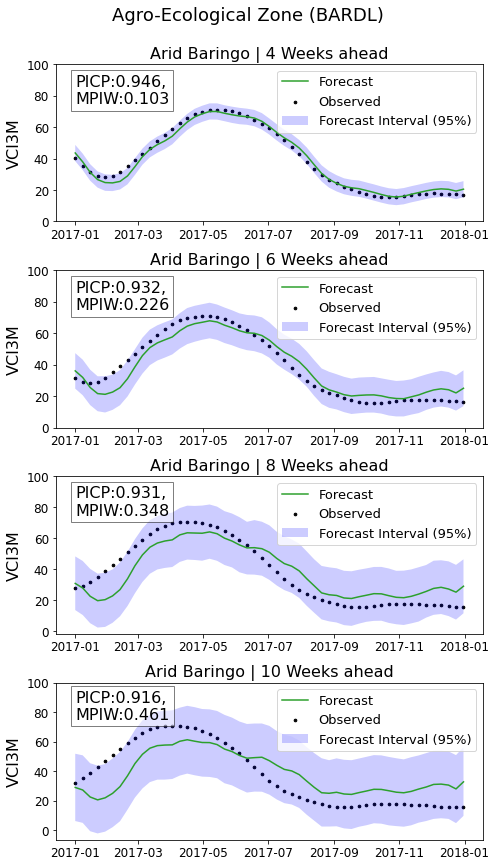

In [40]:
coi = ['Baringo', 'Arid']
select_df0 = UnPool_df[UnPool_df.County==coi[0]]
select_df = select_df0[select_df0.AEZ==coi[1]]

select_df['Date'] = pd.to_datetime(select_df.Date)
select_df = select_df[select_df.Date.dt.year==2017]
# date = pd.date_range(start='2018-01-07', end='2019-01-06', freq='W')
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(7, 12))
fig.suptitle(f'Agro-Ecological Zone (BARDL)', y=1.0, fontsize=18)
for p, ax in enumerate(axs.reshape(-1)):
    hor = [4,6,8,10][p]
    pred_sub = select_df[select_df['Horizon']==hor]
    cp = UPICP_county[(UPICP_county['County']==coi[0])&(UPICP_county['AEZ']==coi[1])][f'PICP_{hor}'].values[0]
    iw = UPICP_county[(UPICP_county['County']==coi[0])&(UPICP_county['AEZ']==coi[1])][f'MPIW_{hor}'].values[0]
#     mae2 = mean_absolute_error(pred_sub.VCI_Observed.values, pred_sub.VCI_Forecast.values)
#     r2 = r2_score(pred_sub.VCI_Observed.values, pred_sub.VCI_Forecast.values)
    
    ax.set_title(f'{coi[1]} {coi[0]} | {hor} Weeks ahead',fontsize=16)
    ax.scatter(pred_sub.Date, pred_sub.VCI_Observed*100, s=7, color='k', label='Observed')
    ax.plot(pred_sub.Date, pred_sub.VCI_Forecast*100, color='#2ca02c', label='Forecast')
    ax.fill_between(pred_sub.Date, pred_sub.VCI_Upper1*100, pred_sub.VCI_Lower0*100, facecolor='blue', alpha=0.2, label='Forecast Interval (95%)')
    ax.set_ylabel('VCI3M',fontsize=16)
    ax.set_yticks(np.arange(0, 120, 20))
#     ax.set_xticks(np.arange(0, 120, 20))
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    txt = ax.text(x=pred_sub.Date.values[0], y=75,
                      s=f'PICP:{cp.round(3)},\nMPIW:{iw.round(3)}',fontsize=16)
    txt.set_bbox(dict(facecolor='white', alpha=0.5))

    ax.legend(loc='upper right', fontsize=13)
    plt.tight_layout()
plt.savefig(f'UnPoolPICP_MPIW_VCI3M_AEZ_{coi[1]}3.pdf', dpi=300, bbox_inches='tight')

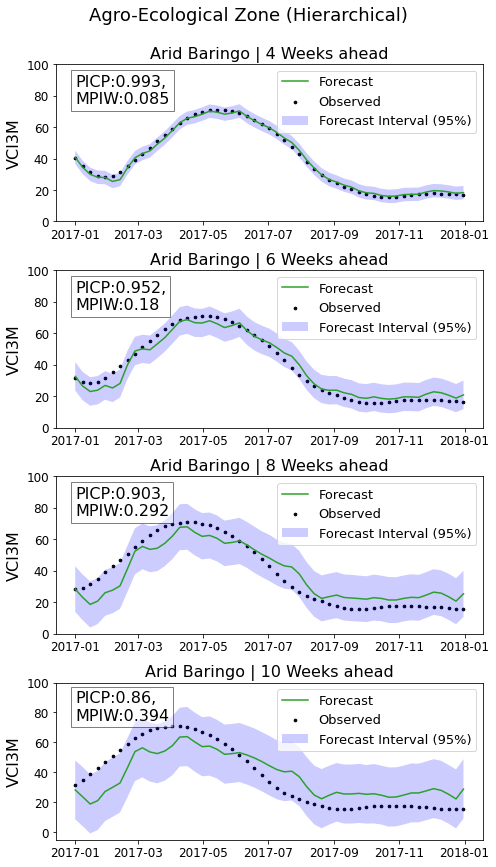

In [39]:
coi = ['Baringo', 'Arid']
select = []
select_df0 = PartPoolTr[PartPoolTr.County==coi[0]]
select_df = select_df0[select_df0.AEZ==coi[1]]
select_df['Date'] = pd.to_datetime(select_df.Date)
select_df = select_df[select_df.Date.dt.year==2017]

# date = pd.date_range(start='2018-01-07', end='2019-01-06', freq='W')
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(7, 12))
fig.suptitle(f'Agro-Ecological Zone (Hierarchical)', y=1.0, fontsize=18)
for p, ax in enumerate(axs.reshape(-1)):
    hor = [4,6,8,10][p]
    pred_sub = select_df[select_df['Horizon']==hor]
    cp = PPICP_county[(PPICP_county['County']==coi[0])&(PPICP_county['AEZ']==coi[1])][f'PICP_{hor}'].values[0]
    iw = PPICP_county[(PPICP_county['County']==coi[0])&(PPICP_county['AEZ']==coi[1])][f'MPIW_{hor}'].values[0]
#     mae2 = mean_absolute_error(pred_sub.VCI_Observed.values, pred_sub.VCI_Forecast.values)
#     r2 = r2_score(pred_sub.VCI_Observed.values, pred_sub.VCI_Forecast.values)
    
    ax.set_title(f'{coi[1]} {coi[0]} | {hor} Weeks ahead',fontsize=16)
    ax.scatter(pred_sub.Date, pred_sub.VCI_Observed*100, s=7, color='k', label='Observed')
    ax.plot(pred_sub.Date, pred_sub.VCI_Forecast*100, color='#2ca02c', label='Forecast')
    ax.fill_between(pred_sub.Date, pred_sub.VCI_Upper1*100, pred_sub.VCI_Lower0*100, facecolor='blue', alpha=0.2, label='Forecast Interval (95%)')
    ax.set_ylabel('VCI3M',fontsize=16)
    ax.set_yticks(np.arange(0, 120, 20))
#     ax.set_xticks(np.arange(0, 120, 20))
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    txt = ax.text(x=pred_sub.Date.values[0], y=75,
                      s=f'PICP:{cp.round(3)},\nMPIW:{iw.round(3)}',fontsize=16)
    txt.set_bbox(dict(facecolor='white', alpha=0.5))

    ax.legend(loc='upper right', fontsize=13)
    plt.tight_layout()
plt.savefig(f'HierarchicalPICP_MPIW_VCI3M_AEZ_{coi[1]}3.pdf', dpi=300, bbox_inches='tight')